# Introduction to Bayesian Time Series Analysis with PyMC

#### PyData London 2025

**Instructor**: Chris Fonnesbeck  
**Duration**: 90 minutes  
**Level**: Intermediate  

---

## Tutorial Overview

Time series data are everywhere in modern data science—from stock prices and sensor readings to epidemiological counts and climate measurements. Traditional approaches to time series analysis often treat uncertainty as an afterthought, providing point estimates without properly quantifying the confidence we should have in our predictions. **Bayesian time series analysis** fundamentally changes this perspective by placing uncertainty quantification at the center of the modeling process.

This comprehensive tutorial introduces the **powerful combination** of Bayesian statistical methods and PyMC's probabilistic programming framework for time series analysis. We will explore how Bayesian approaches naturally handle the inherent uncertainty in time series data while providing a unified framework for modeling everything from simple trends to complex, multivariate state-space models.

**Why Bayesian time series analysis matters**: Unlike classical methods that provide single-valued forecasts, Bayesian approaches give us complete **probability distributions** over future values. This allows us to answer questions like "What is the probability that sales will exceed our target next quarter?" rather than just "What do we expect sales to be?" This probabilistic perspective is essential for decision-making under uncertainty.

---

## Learning Objectives

By the end of this tutorial, you will be able to:

1. **Understand the fundamental advantages** of Bayesian approaches for time series analysis, including uncertainty quantification and the ability to incorporate prior knowledge
2. **Master PyMC's specialized time series distributions** (`pm.GaussianRandomWalk`, `pm.AR`, `pm.MvGaussianRandomWalk`) and understand when to use each
3. **Implement and compare multiple Bayesian time series models**, from simple random walks to sophisticated state-space models with time-varying parameters
4. **Handle real-world time series challenges** including missing data, irregular spacing, and multiple seasonality patterns
5. **Perform rigorous model evaluation** using posterior predictive checks, information criteria, and time series-specific validation techniques
6. **Generate probabilistic forecasts** with proper uncertainty quantification and understand how to communicate these results effectively
7. **Apply these techniques** to diverse real-world datasets spanning finance, epidemiology, and operational metrics

---

## Prerequisites

To get the most out of this tutorial, you should have:

- **Solid Python programming skills**, including familiarity with NumPy, Pandas, and Matplotlib
- **Understanding of basic time series concepts** such as trend, seasonality, and autocorrelation (we will review these)
- **Basic knowledge of probability and statistics**, including concepts like probability distributions and statistical inference
- **Some exposure to Bayesian inference** (helpful but not required—we will provide a focused review)
- **Familiarity with linear regression concepts** and the general idea of statistical modeling

If you're new to Bayesian methods, don't worry! We'll provide all the necessary background as we go.

---

## Tutorial Structure

This tutorial follows a carefully designed progression from foundational concepts to advanced applications:

| **Section** | **Topic** | **Duration** | **Key Learning** |
|-------------|-----------|--------------|------------------|
| **1** | Motivation & Fundamentals | 20 min | Why Bayesian? Time series characteristics |
| **2** | Bayesian Inference & PyMC | 10 min | Bayes' theorem, MCMC, PyMC workflow |
| **3** | Basic Bayesian Time Series | 20 min | Random walks, trend models, seasonality |
| **4** | Advanced Models | 25 min | State-space models, stochastic volatility, GPs |
| **5** | Model Evaluation | 10 min | Posterior checks, information criteria |
| **6** | Forecasting | 10 min | Probabilistic predictions, uncertainty |

---

## Useful Resources

- **[PyMC Documentation](https://docs.pymc.io/)**: Comprehensive guide to PyMC's capabilities
- **[ArviZ Documentation](https://arviz-devs.github.io/arviz/)**: Essential for Bayesian model analysis and visualization
- **[Time Series Analysis Handbook](https://otexts.com/fpp3/)**: Excellent coverage of classical time series methods for comparison
- **[Bayesian Data Analysis](http://www.stat.columbia.edu/~gelman/book/)**: The definitive reference for Bayesian methods
- **[PyMC Examples Gallery](https://docs.pymc.io/en/stable/learn/gallery.html)**: Real-world applications and advanced techniques

In [99]:
# Import necessary libraries
import numpy as np
import polars as pl
import matplotlib.pyplot as plt
# import seaborn as sns
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings
from scipy import stats
from scipy.stats import jarque_bera, shapiro
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots
import os

plt.style.use('seaborn-v0_8')
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['figure.dpi'] = 100
warnings.filterwarnings('ignore')

np.random.seed(42)
RANDOM_SEED = 42

---

## Section 1: Introduction and Motivation (20 minutes)

### The Power of Bayesian Thinking for Time Series

Traditional time series analysis has served us well for decades, but it suffers from a fundamental limitation: **uncertainty is often treated as an afterthought**. When we build an ARIMA model or apply exponential smoothing, we typically get point forecasts with some measure of "confidence intervals" that are often based on strong distributional assumptions and may not reflect the true uncertainty in our predictions.

**Bayesian time series analysis fundamentally changes this perspective** by treating uncertainty as a first-class citizen throughout the entire modeling process. Instead of obtaining single-valued predictions, we get complete **probability distributions** over all possible future values, conditioned on our data and our modeling assumptions.

### Why Bayesian Methods Excel for Time Series

#### 1. Natural Uncertainty Quantification

Consider predicting next month's sales. A classical approach might tell us "we expect 1,000 units ± 100." But what does this really mean? Are we 90% confident? 95%? What's the shape of this uncertainty—is it symmetric or skewed?

A Bayesian approach instead tells us: "There's a 20% chance sales will be below 950 units, a 50% chance they'll be between 950 and 1,050, and a 30% chance they'll exceed 1,050." This **probabilistic language** is much more natural for decision-making under uncertainty.

#### 2. Incorporating Prior Knowledge

Time series data often come with rich domain knowledge. We might know that:
- Sales are typically higher in December due to holiday shopping
- Stock volatility tends to cluster (high volatility periods are followed by more high volatility)
- Economic indicators don't change dramatically from day to day

**Bayesian methods provide a principled way to incorporate this knowledge** through prior distributions, rather than treating each dataset as if we know nothing about the world.

#### 3. Unified Framework for Complex Models

Bayesian approaches allow us to naturally handle:
- **Missing data**: Rather than imputing or interpolating, we can model missingness directly
- **Irregular spacing**: No need to artificially regularize timestamps
- **Multiple seasonality**: Hierarchical models naturally accommodate daily, weekly, and yearly patterns
- **Changing relationships**: Time-varying parameters are natural in the Bayesian framework

#### 4. Robust to Model Uncertainty

Instead of selecting a single "best" model, Bayesian methods allow us to:
- **Average across multiple models** weighted by their posterior probability
- **Quantify structural uncertainty** in addition to parameter uncertainty  
- **Adaptively update models** as new data arrive

### Key Characteristics of Time Series Data

Before diving into Bayesian methods, let's establish a solid foundation in time series fundamentals. Understanding these characteristics is crucial for building appropriate models.

#### The Nature of Temporal Dependence

The defining characteristic of time series data is **temporal dependence**—observations that are close in time are typically more similar than observations that are far apart. This violates the independence assumption that underlies most statistical methods, requiring specialized approaches.

**Mathematically**, we can express this as:

$$\text{Corr}(y_t, y_{t+h}) \neq 0$$

for some lag $h > 0$. This **autocorrelation** is what makes time series prediction possible—if future values were completely unrelated to past values, prediction would be impossible.

#### Fundamental Components of Time Series

Most time series can be decomposed into several interpretable components:

1. **Trend ($T_t$)**: The long-term direction of the data
2. **Seasonality ($S_t$)**: Regular, predictable patterns that repeat over fixed periods
3. **Cyclical patterns ($C_t$)**: Longer-term fluctuations without fixed periods
4. **Irregular/Noise ($\epsilon_t$)**: Random fluctuations that cannot be explained by the other components

We can write this **decomposition** as either:

**Additive**: $y_t = T_t + S_t + C_t + \epsilon_t$

**Multiplicative**: $y_t = T_t \times S_t \times C_t \times \epsilon_t$

The choice between additive and multiplicative depends on whether the seasonal fluctuations change proportionally with the level of the series.

In [100]:
# Let's start by examining real time series data to understand these concepts
# We'll use the births dataset as it clearly demonstrates trend and seasonality

import numpy as np
import polars as pl
import pymc as pm
import pytensor.tensor as pt
import arviz as az
import warnings
from scipy import stats
import plotly.graph_objects as go
import plotly.express as px
from plotly.subplots import make_subplots

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Random seed for reproducibility
np.random.seed(42)
RANDOM_SEED = 42

print("📊 Libraries loaded successfully!")
print("PyMC version:", pm.__version__)
print("ArviZ version:", az.__version__)
print("NumPy version:", np.__version__)
print("Polars version:", pl.__version__)

📊 Libraries loaded successfully!
PyMC version: 5.22.0
ArviZ version: 0.21.0
NumPy version: 2.2.5
Polars version: 1.27.1


In [101]:
# Load and explore the births dataset using Polars - a classic time series example
# Handle null values in the data
births_data = pl.read_csv('../data/births.csv', null_values=['null', 'NA', '', 'NULL'])

# Filter out rows with null days if any exist
births_data = births_data.filter(pl.col('day').is_not_null())

# Instead of creating dates directly, let's aggregate first to avoid invalid date issues
# Since we're aggregating to monthly data anyway, we don't need the exact dates
monthly_births = (births_data
    .group_by(['year', 'month'])
    .agg(pl.col('births').sum())
    .sort(['year', 'month'])
)

# Now create valid dates using the first day of each month
monthly_births = monthly_births.with_columns([
    pl.date(pl.col('year'), pl.col('month'), 1).alias('date')
])

# Focus on a 20-year period for clarity (1970-1990)
births_subset = (monthly_births
    .filter((pl.col('year') >= 1970) & (pl.col('year') <= 1990))
    .with_row_index('index')
)

print(f"📈 Births Dataset Overview:")
print(f"   • Total months: {births_subset.height}")
print(f"   • Date range: {births_subset['year'].min()} to {births_subset['year'].max()}")
print(f"   • Monthly births range: {births_subset['births'].min():,} to {births_subset['births'].max():,}")
print(f"   • Average monthly births: {births_subset['births'].mean():.0f}")
print(f"   • Standard deviation: {births_subset['births'].std():.0f}")

# Display the first few observations
print(f"\n📋 First few observations:")
print(births_subset.select(['year', 'month', 'births']).head(10))

📈 Births Dataset Overview:
   • Total months: 228
   • Date range: 1970 to 1988
   • Monthly births range: 237,302 to 354,599
   • Average monthly births: 293389
   • Standard deviation: 25082

📋 First few observations:
shape: (10, 3)
┌──────┬───────┬────────┐
│ year ┆ month ┆ births │
│ ---  ┆ ---   ┆ ---    │
│ i64  ┆ i64   ┆ i64    │
╞══════╪═══════╪════════╡
│ 1970 ┆ 1     ┆ 302278 │
│ 1970 ┆ 2     ┆ 281488 │
│ 1970 ┆ 3     ┆ 307448 │
│ 1970 ┆ 4     ┆ 287090 │
│ 1970 ┆ 5     ┆ 298140 │
│ 1970 ┆ 6     ┆ 303378 │
│ 1970 ┆ 7     ┆ 330452 │
│ 1970 ┆ 8     ┆ 331326 │
│ 1970 ┆ 9     ┆ 332496 │
│ 1970 ┆ 10    ┆ 324422 │
└──────┴───────┴────────┘


In [102]:
# Create comprehensive visualization of time series components using Plotly
# Convert Polars data to numpy arrays for plotting
dates = births_subset['date'].to_numpy()
births_values = births_subset['births'].to_numpy()

# 1. Main time series plot showing overall pattern
fig_main = go.Figure()

fig_main.add_trace(go.Scatter(
    x=dates, 
    y=births_values,
    mode='lines+markers',
    name='Monthly Births',
    line=dict(width=2),
    marker=dict(size=4)
))

# Add trend line
z = np.polyfit(range(len(births_values)), births_values, 1)
p = np.poly1d(z)
fig_main.add_trace(go.Scatter(
    x=dates, 
    y=p(range(len(births_values))),
    mode='lines',
    name=f'Trend (slope={z[0]:.0f} births/month)',
    line=dict(color='red', dash='dash', width=3)
))

fig_main.update_layout(
    title='Monthly Birth Counts (1970-1990)<br>Showing Trend and Seasonal Patterns',
    xaxis_title='Year',
    yaxis_title='Number of Births',
    width=800,
    height=500,
    showlegend=True
)
fig_main.show()

# 2. Seasonal pattern analysis using Polars
monthly_avg = (births_subset
    .group_by('month')
    .agg([
        pl.col('births').mean().alias('mean'),
        pl.col('births').std().alias('std')
    ])
    .sort('month')
)

month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
               'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']

fig_seasonal = go.Figure()
fig_seasonal.add_trace(go.Bar(
    x=month_names,
    y=monthly_avg['mean'].to_numpy(),
    error_y=dict(type='data', array=monthly_avg['std'].to_numpy(), visible=True),
    name='Average Births',
    marker_color='skyblue'
))

fig_seasonal.update_layout(
    title='Seasonal Pattern: Average Births by Month<br>(Error bars show ± 1 standard deviation)',
    xaxis_title='Month',
    yaxis_title='Average Number of Births',
    width=800,
    height=500
)
fig_seasonal.show()

# 3. Distribution of values
fig_dist = go.Figure()
fig_dist.add_trace(go.Histogram(
    x=births_values,
    nbinsx=25,
    name='Birth Counts',
    opacity=0.7,
    marker_color='lightgreen'
))

fig_dist.add_vline(
    x=births_subset['births'].mean(),
    line_dash="dash",
    line_color="red",
    annotation_text=f"Mean: {births_subset['births'].mean():.0f}"
)

fig_dist.add_vline(
    x=births_subset.select(pl.col('births').median())['births'][0],
    line_dash="dash", 
    line_color="blue",
    annotation_text=f"Median: {births_subset.select(pl.col('births').median())['births'][0]:.0f}"
)

fig_dist.update_layout(
    title='Distribution of Monthly Birth Counts<br>Showing Central Tendency',
    xaxis_title='Number of Births',
    yaxis_title='Frequency',
    width=800,
    height=500
)
fig_dist.show()

# 4. Autocorrelation function to show temporal dependence
def compute_autocorrelation(series, max_lags=24):
    """Compute sample autocorrelation function"""
    series = np.array(series)
    n = len(series)
    series = series - np.mean(series)
    autocorrs = []
    
    for lag in range(max_lags + 1):
        if lag == 0:
            autocorr = 1.0
        else:
            if len(series) > lag:
                c_lag = np.mean(series[:-lag] * series[lag:])
                c_0 = np.mean(series * series)
                autocorr = c_lag / c_0 if c_0 != 0 else 0
            else:
                autocorr = 0
        autocorrs.append(autocorr)
    
    return autocorrs

lags = list(range(25))
autocorr_values = compute_autocorrelation(births_values, 24)

fig_acf = go.Figure()
fig_acf.add_trace(go.Bar(
    x=lags,
    y=autocorr_values,
    name='Autocorrelation',
    marker_color='orange'
))

fig_acf.add_hline(y=0, line_color="black", line_width=1)
fig_acf.add_hline(y=0.2, line_dash="dash", line_color="red", 
                 annotation_text="Significance threshold")
fig_acf.add_hline(y=-0.2, line_dash="dash", line_color="red")

fig_acf.update_layout(
    title='Autocorrelation Function<br>Showing Temporal Dependence',
    xaxis_title='Lag (months)',
    yaxis_title='Autocorrelation',
    width=800,
    height=500
)
fig_acf.show()

# Print key insights
peak_month_idx = monthly_avg['mean'].arg_max()
trough_month_idx = monthly_avg['mean'].arg_min()
peak_month = month_names[peak_month_idx]
trough_month = month_names[trough_month_idx]
seasonal_range = monthly_avg['mean'].max() - monthly_avg['mean'].min()

print(f"\n🔍 Key Time Series Characteristics Observed:")
print(f"   • **Trend**: {z[0]:.0f} births per month {'increase' if z[0] > 0 else 'decrease'} over 20 years")
print(f"   • **Seasonality**: Clear annual pattern with peak in {peak_month} and trough in {trough_month}")
print(f"   • **Seasonal range**: {seasonal_range:.0f} births between peak and trough months")
print(f"   • **Autocorrelation**: Strong at lag 12 (annual pattern), weaker but significant at shorter lags")
print(f"   • **Distribution**: Approximately normal with slight right skew")


🔍 Key Time Series Characteristics Observed:
   • **Trend**: 220 births per month increase over 20 years
   • **Seasonality**: Clear annual pattern with peak in Aug and trough in Feb
   • **Seasonal range**: 47190 births between peak and trough months
   • **Autocorrelation**: Strong at lag 12 (annual pattern), weaker but significant at shorter lags
   • **Distribution**: Approximately normal with slight right skew


### Understanding Stationarity and Autocorrelation

Two concepts are absolutely crucial for understanding time series behavior: **stationarity** and **autocorrelation**. These concepts determine what modeling approaches are appropriate and how we should interpret our results.

#### Understanding Stationarity

**Stationarity** is a statistical property that describes whether a time series has constant statistical properties over time. A time series is **strictly stationary** if its statistical properties don't change when shifted in time. In practice, we usually work with **weak stationarity** (also called covariance stationarity), which requires:

1. **Constant mean**: $E[y_t] = \mu$ for all $t$
2. **Constant variance**: $\text{Var}(y_t) = \sigma^2$ for all $t$  
3. **Autocovariance depends only on lag**: $\text{Cov}(y_t, y_{t+h}) = \gamma(h)$ for all $t$

**Why does stationarity matter?** Most time series models assume some form of stationarity. If our data violates these assumptions, our models may:
- Give unreliable parameter estimates
- Produce poor forecasts
- Exhibit spurious relationships between unrelated variables

#### Types of Non-Stationarity

Our births data exhibits several types of non-stationarity:

1. **Trend non-stationarity**: The mean is changing over time (slight upward trend)
2. **Seasonal non-stationarity**: Regular patterns repeat annually
3. **Variance stationarity**: The variance appears relatively constant (good!)

#### The Autocorrelation Function (ACF)

The **autocorrelation function** measures the linear relationship between observations separated by $h$ time periods:

$$\rho(h) = \frac{\text{Cov}(y_t, y_{t+h})}{\sqrt{\text{Var}(y_t) \text{Var}(y_{t+h})}} = \frac{\gamma(h)}{\gamma(0)}$$

**Key insights from our ACF plot**:
- **High autocorrelation at lag 12**: This confirms annual seasonality
- **Gradual decay**: Typical of series with trend
- **Oscillating pattern**: Suggests seasonal cycles

#### Partial Autocorrelation Function (PACF)

The **partial autocorrelation** at lag $h$ measures the correlation between $y_t$ and $y_{t+h}$ after removing the effects of intermediate lags $y_{t+1}, y_{t+2}, \ldots, y_{t+h-1}$. This helps identify the **order** of autoregressive processes.

Let's compute and visualize these important diagnostic tools:

In [103]:
# Advanced time series diagnostics: ACF, PACF, and stationarity tests using Plotly
def compute_pacf(series, max_lags=24):
    """Compute partial autocorrelation function using Yule-Walker equations"""
    series = np.array(series)
    series = series - np.mean(series)
    n = len(series)
    
    # Compute autocorrelations first
    autocorrs = []
    for lag in range(max_lags + 1):
        if lag == 0:
            autocorr = 1.0
        else:
            c_lag = np.mean(series[:-lag] * series[lag:])
            c_0 = np.mean(series * series)
            autocorr = c_lag / c_0
        autocorrs.append(autocorr)
    
    # Compute partial autocorrelations using Yule-Walker recursion
    pacf = [1.0]  # PACF at lag 0 is always 1
    
    for k in range(1, max_lags + 1):
        if k == 1:
            pacf.append(autocorrs[1])
        else:
            # Build the Toeplitz matrix for Yule-Walker equations
            r_matrix = np.array([[autocorrs[abs(i-j)] for j in range(k)] for i in range(k)])
            r_vector = np.array([autocorrs[i+1] for i in range(k)])
            
            try:
                phi = np.linalg.solve(r_matrix, r_vector)
                pacf.append(phi[-1])
            except np.linalg.LinAlgError:
                pacf.append(0.0)
    
    return pacf

# Compute ACF and PACF using Polars data
max_lags = 36
births_values = births_subset['births'].to_numpy()
acf_values = compute_autocorrelation(births_values, max_lags)
pacf_values = compute_pacf(births_values, max_lags)

# Create comprehensive diagnostic plots using subplots
fig = make_subplots(
    rows=2, cols=2,
    subplot_titles=(
        'Autocorrelation Function (ACF)<br>Showing Strong Seasonality at Lag 12',
        'Partial Autocorrelation Function (PACF)<br>Showing Direct Relationships',
        'Rolling Mean Analysis<br>Testing for Trend Stationarity',
        'Rolling Standard Deviation<br>Testing for Variance Stationarity'
    ),
    vertical_spacing=0.12
)

# 1. ACF plot with significance bounds
lags = list(range(max_lags + 1))
n = len(births_subset)
se = 1.96 / np.sqrt(n)  # 95% confidence bounds

fig.add_trace(go.Bar(
    x=lags, y=acf_values,
    name='ACF',
    marker_color='blue',
    opacity=0.7
), row=1, col=1)

fig.add_hline(y=se, line_dash="dash", line_color="red", row=1, col=1)
fig.add_hline(y=-se, line_dash="dash", line_color="red", row=1, col=1)
fig.add_hline(y=0, line_color="black", line_width=1, row=1, col=1)

# 2. PACF plot
fig.add_trace(go.Bar(
    x=lags, y=pacf_values,
    name='PACF',
    marker_color='orange',
    opacity=0.7
), row=1, col=2)

fig.add_hline(y=se, line_dash="dash", line_color="red", row=1, col=2)
fig.add_hline(y=-se, line_dash="dash", line_color="red", row=1, col=2)
fig.add_hline(y=0, line_color="black", line_width=1, row=1, col=2)

# 3. Rolling statistics to assess stationarity using Polars
window_size = 24  # 2-year rolling window

# Compute rolling statistics using NumPy since Polars doesn't have rolling for all operations
dates_array = births_subset['date'].to_numpy()
births_array = births_subset['births'].to_numpy()

# Compute rolling mean and std manually
rolling_mean = np.full_like(births_array, np.nan, dtype=float)
rolling_std = np.full_like(births_array, np.nan, dtype=float)

for i in range(window_size//2, len(births_array) - window_size//2):
    start_idx = max(0, i - window_size//2)
    end_idx = min(len(births_array), i + window_size//2 + 1)
    rolling_mean[i] = np.mean(births_array[start_idx:end_idx])
    rolling_std[i] = np.std(births_array[start_idx:end_idx])

fig.add_trace(go.Scatter(
    x=dates_array, 
    y=births_array,
    mode='lines+markers',
    name='Original data',
    opacity=0.5,
    marker=dict(size=2),
    line=dict(width=1)
), row=2, col=1)

# Only plot rolling mean where we have valid values
valid_mask = ~np.isnan(rolling_mean)
fig.add_trace(go.Scatter(
    x=dates_array[valid_mask], 
    y=rolling_mean[valid_mask],
    mode='lines',
    name=f'{window_size}-month rolling mean',
    line=dict(color='red', width=3)
), row=2, col=1)

# 4. Rolling standard deviation
valid_std_mask = ~np.isnan(rolling_std)
fig.add_trace(go.Scatter(
    x=dates_array[valid_std_mask], 
    y=rolling_std[valid_std_mask],
    mode='lines',
    name=f'{window_size}-month rolling std',
    line=dict(color='green', width=2)
), row=2, col=2)

overall_std = births_subset['births'].std()
fig.add_hline(
    y=overall_std, 
    line_dash="dash", 
    line_color="red",
    annotation_text=f"Overall std: {overall_std:.0f}",
    row=2, col=2
)

# Update layout
fig.update_xaxes(title_text="Lag (months)", row=1, col=1)
fig.update_xaxes(title_text="Lag (months)", row=1, col=2)
fig.update_xaxes(title_text="Year", row=2, col=1)
fig.update_xaxes(title_text="Year", row=2, col=2)

fig.update_yaxes(title_text="Autocorrelation", row=1, col=1)
fig.update_yaxes(title_text="Partial Autocorr.", row=1, col=2)
fig.update_yaxes(title_text="Number of Births", row=2, col=1)
fig.update_yaxes(title_text="Standard Deviation", row=2, col=2)

fig.update_layout(
    height=800,
    width=1200,
    showlegend=False,
    title_text="Comprehensive Time Series Diagnostic Analysis"
)

fig.show()

# Statistical tests for stationarity
def simple_stationarity_tests(series):
    """Perform basic stationarity assessments"""
    # Split series into two halves
    mid = len(series) // 2
    first_half = series[:mid]
    second_half = series[mid:]
    
    # Test for mean stationarity
    mean_diff = np.abs(np.mean(second_half) - np.mean(first_half))
    
    # Test for variance stationarity  
    var_ratio = np.var(second_half) / np.var(first_half)
    
    return mean_diff, var_ratio

mean_diff, var_ratio = simple_stationarity_tests(births_values)

print(f"\n🔬 **Stationarity Analysis Results**:")
print(f"\n   **Autocorrelation Insights**:")
print(f"   • Lag 1 ACF: {acf_values[1]:.3f} (moderate positive autocorrelation)")
print(f"   • Lag 12 ACF: {acf_values[12]:.3f} (strong seasonal autocorrelation)")
print(f"   • Lag 1 PACF: {pacf_values[1]:.3f} (direct AR(1) effect)")
print(f"   • Lag 12 PACF: {pacf_values[12]:.3f} (direct seasonal AR effect)")

print(f"\n   **Stationarity Assessment**:")
print(f"   • Mean change between halves: {mean_diff:.0f} births")
print(f"   • Variance ratio (2nd half / 1st half): {var_ratio:.2f}")
print(f"   • Trend evidence: {'Yes' if mean_diff > 1000 else 'Minimal'}")
print(f"   • Variance stability: {'Good' if 0.8 < var_ratio < 1.2 else 'Concerning'}")

print(f"\n   **Model Implications**:")
print(f"   • **Seasonal differencing** may be needed due to strong lag-12 autocorrelation")
print(f"   • **Trend modeling** should account for gradual mean changes")
print(f"   • **AR(1) component** suggested by significant PACF at lag 1")
print(f"   • **Seasonal AR component** suggested by significant PACF at lag 12")


🔬 **Stationarity Analysis Results**:

   **Autocorrelation Insights**:
   • Lag 1 ACF: 0.819 (moderate positive autocorrelation)
   • Lag 12 ACF: 0.865 (strong seasonal autocorrelation)
   • Lag 1 PACF: 0.819 (direct AR(1) effect)
   • Lag 12 PACF: 0.583 (direct seasonal AR effect)

   **Stationarity Assessment**:
   • Mean change between halves: 33060 births
   • Variance ratio (2nd half / 1st half): 0.66
   • Trend evidence: Yes
   • Variance stability: Concerning

   **Model Implications**:
   • **Seasonal differencing** may be needed due to strong lag-12 autocorrelation
   • **Trend modeling** should account for gradual mean changes
   • **AR(1) component** suggested by significant PACF at lag 1
   • **Seasonal AR component** suggested by significant PACF at lag 12


### Data Preprocessing for Time Series Analysis

**Proper data preprocessing** is essential for successful Bayesian time series modeling. Unlike cross-sectional data, time series data have unique challenges that require specialized preprocessing techniques. The quality of our preprocessing directly impacts model performance, interpretability, and computational efficiency.

#### Why Preprocessing Matters for Time Series

1. **Numerical Stability**: Many MCMC samplers are sensitive to the scale of the data. Large values can cause numerical overflow, while tiny values can lead to underflow.

2. **Prior Specification**: When data are on a natural scale, it's easier to specify meaningful priors based on domain knowledge.

3. **Convergence**: Well-scaled data helps MCMC chains converge faster and mix better.

4. **Interpretability**: Standardized parameters are easier to compare across different variables.

#### Essential Preprocessing Steps

##### 1. Handling Missing Values

Time series often have missing observations due to:
- Equipment malfunctions
- Data collection gaps  
- Irregular reporting schedules

**Bayesian approaches** handle missing data naturally by treating missing values as **latent variables** to be estimated along with model parameters. This is a major advantage over classical methods that require imputation or deletion.

##### 2. Normalization and Standardization

**Standardization** transforms data to have mean 0 and standard deviation 1:
$$z_t = \frac{y_t - \bar{y}}{s_y}$$

**Min-Max normalization** scales data to a specific range (e.g., [0,1]):
$$y_t^{norm} = \frac{y_t - \min(y)}{\max(y) - \min(y)}$$

**Log transformation** is useful for:
- Data that span several orders of magnitude
- Series that exhibit multiplicative seasonality
- Ensuring positivity

$$y_t^{log} = \log(y_t)$$

##### 3. Trend and Seasonality Decomposition

**Classical decomposition** separates a time series into its constituent components:

$$y_t = T_t + S_t + R_t \quad \text{(additive)}$$
$$y_t = T_t \times S_t \times R_t \quad \text{(multiplicative)}$$

Where:
- $T_t$ = trend component
- $S_t$ = seasonal component  
- $R_t$ = remainder/irregular component

**STL decomposition** (Seasonal and Trend decomposition using Loess) provides a more robust alternative that handles:
- Changing seasonal patterns
- Missing values
- Outliers

Let's implement these preprocessing techniques on our births data:

In [104]:
# Comprehensive preprocessing demonstration using Plotly
def manual_stl_decomposition(series, period=12, trend_window=None):
    """
    Manual implementation of basic seasonal decomposition
    This is simplified compared to full STL but demonstrates the concepts
    """
    if trend_window is None:
        trend_window = period * 2 + 1
    
    series_array = np.array(series)
    
    # Step 1: Extract trend using centered moving average
    trend = np.full_like(series_array, np.nan, dtype=float)
    half_window = trend_window // 2
    
    for i in range(half_window, len(series_array) - half_window):
        trend[i] = np.mean(series_array[i-half_window:i+half_window+1])
    
    # Fill NaN values with forward/backward fill equivalent
    trend = np.where(np.isnan(trend), 
                    np.nanmean(trend), trend)
    
    # Step 2: Detrend the series
    detrended = series_array - trend
    
    # Step 3: Estimate seasonal component by averaging within each season
    seasonal = np.zeros_like(series_array)
    for i in range(period):
        mask = np.arange(i, len(series_array), period)
        if len(mask) > 0:
            seasonal[mask] = np.mean(detrended[mask])
    
    # Step 4: Calculate residual
    residual = series_array - trend - seasonal
    
    return trend, seasonal, residual

# Apply different preprocessing transformations using Polars
original_data = births_subset['births'].to_numpy()

# 1. Standardization
standardized = (original_data - original_data.mean()) / original_data.std()

# 2. Min-Max normalization  
min_max_norm = (original_data - original_data.min()) / (original_data.max() - original_data.min())

# 3. Log transformation
log_transform = np.log(original_data)

# 4. Seasonal decomposition
trend, seasonal, residual = manual_stl_decomposition(original_data, period=12)

# Create comprehensive preprocessing visualization using subplots
fig = make_subplots(
    rows=3, cols=2,
    subplot_titles=(
        'Original Data<br>Monthly Birth Counts',
        'Standardized Data<br>(Mean=0, Std=1)',
        'Min-Max Normalized Data<br>(Range: [0,1])',
        'Log Transformed Data<br>Natural Logarithm',
        'Decomposition: Trend and Seasonal<br>Separating Components',
        'Residuals After Decomposition<br>What\'s Left to Explain'
    ),
    vertical_spacing=0.08
)

# Get dates for plotting
dates = births_subset['date'].to_numpy()

# Original data
fig.add_trace(go.Scatter(
    x=dates, y=original_data,
    mode='lines',
    name='Original',
    line=dict(color='blue', width=2)
), row=1, col=1)

# Standardized data  
fig.add_trace(go.Scatter(
    x=dates, y=standardized,
    mode='lines',
    name='Standardized',
    line=dict(color='red', width=2)
), row=1, col=2)

fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5, row=1, col=2)

# Min-Max normalized data
fig.add_trace(go.Scatter(
    x=dates, y=min_max_norm,
    mode='lines',
    name='Min-Max Norm',
    line=dict(color='green', width=2)
), row=2, col=1)

# Log transformed data
fig.add_trace(go.Scatter(
    x=dates, y=log_transform,
    mode='lines',
    name='Log Transform',
    line=dict(color='purple', width=2)
), row=2, col=2)

# Seasonal decomposition - trend and seasonal
fig.add_trace(go.Scatter(
    x=dates, y=original_data,
    mode='lines',
    name='Original',
    line=dict(color='blue', width=1),
    opacity=0.5
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=dates, y=trend,
    mode='lines',
    name='Trend',
    line=dict(color='red', width=3)
), row=3, col=1)

fig.add_trace(go.Scatter(
    x=dates, y=seasonal + original_data.mean(),
    mode='lines',
    name='Seasonal (shifted)',
    line=dict(color='green', width=2)
), row=3, col=1)

# Residuals after decomposition
fig.add_trace(go.Scatter(
    x=dates, y=residual,
    mode='lines',
    name='Residuals',
    line=dict(color='orange', width=2)
), row=3, col=2)

fig.add_hline(y=0, line_dash="dash", line_color="black", opacity=0.5, row=3, col=2)

# Update axes labels
fig.update_xaxes(title_text="Year", row=3, col=1)
fig.update_xaxes(title_text="Year", row=3, col=2)

fig.update_yaxes(title_text="Births", row=1, col=1)
fig.update_yaxes(title_text="Std. Values", row=1, col=2)
fig.update_yaxes(title_text="Norm. Values", row=2, col=1)
fig.update_yaxes(title_text="Log(Births)", row=2, col=2)
fig.update_yaxes(title_text="Births", row=3, col=1)
fig.update_yaxes(title_text="Residuals", row=3, col=2)

fig.update_layout(
    height=1000,
    width=1200,
    showlegend=False,
    title_text="Comprehensive Data Preprocessing Analysis"
)

fig.show()

# Comparative statistics
print("🔧 **Preprocessing Results Summary**:")
print("="*50)

transformations = {
    'Original': original_data,
    'Standardized': standardized, 
    'Min-Max Norm': min_max_norm,
    'Log Transform': log_transform,
    'Residuals': residual
}

print(f"{'Transformation':<15} {'Mean':<10} {'Std':<10} {'Min':<10} {'Max':<10} {'Range':<10}")
print("-" * 75)

for name, data in transformations.items():
    mean_val = np.mean(data)
    std_val = np.std(data)
    min_val = np.min(data)
    max_val = np.max(data)
    range_val = max_val - min_val
    
    print(f"{name:<15} {mean_val:<10.2f} {std_val:<10.2f} {min_val:<10.2f} {max_val:<10.2f} {range_val:<10.2f}")

print(f"\n**Key Insights**:")
print(f"• **Standardization** centers data around 0 with unit variance - ideal for MCMC")
print(f"• **Min-Max normalization** bounds data in [0,1] - useful for bounded priors")
print(f"• **Log transformation** reduces right skew and multiplicative effects")
print(f"• **Decomposition** reduces residual variance by {(1-np.std(residual)/original_data.std())*100:.1f}% - simpler patterns to model")

# Choose standardized data for modeling
births_standardized = standardized
print(f"\n✅ **Selected preprocessing**: Standardized data (mean=0, std=1)")
print(f"   This choice provides:")
print(f"   • Numerical stability for MCMC sampling")
print(f"   • Easy interpretation of parameters")
print(f"   • Natural scale for prior specification")

🔧 **Preprocessing Results Summary**:
Transformation  Mean       Std        Min        Max        Range     
---------------------------------------------------------------------------
Original        293389.19  25026.93   237302.00  354599.00  117297.00 
Standardized    -0.00      1.00       -2.24      2.45       4.69      
Min-Max Norm    0.48       0.21       0.00       1.00       1.00      
Log Transform   12.59      0.09       12.38      12.78      0.40      
Residuals       0.21       10269.33   -16158.32  41202.10   57360.42  

**Key Insights**:
• **Standardization** centers data around 0 with unit variance - ideal for MCMC
• **Min-Max normalization** bounds data in [0,1] - useful for bounded priors
• **Log transformation** reduces right skew and multiplicative effects
• **Decomposition** reduces residual variance by 59.0% - simpler patterns to model

✅ **Selected preprocessing**: Standardized data (mean=0, std=1)
   This choice provides:
   • Numerical stability for MCMC samplin

---

## Section 2: Bayesian Inference and PyMC (10 minutes)

Now that we understand the characteristics of time series data and how to preprocess it effectively, we need to establish the **theoretical foundation** for Bayesian inference and understand how PyMC implements these concepts for time series modeling.

### The Bayesian Paradigm: A Fundamental Shift in Thinking

**Bayesian inference** represents a fundamentally different approach to statistical modeling compared to classical (frequentist) methods. While classical statistics treats parameters as fixed but unknown constants, **Bayesian statistics treats parameters as random variables** with their own probability distributions.

This shift in perspective has profound implications for time series analysis:

1. **Uncertainty quantification**: We get full probability distributions over parameters and predictions
2. **Sequential learning**: We can naturally update our beliefs as new data arrive
3. **Missing data**: Unobserved values are just additional random variables to estimate
4. **Hierarchical modeling**: Complex, multi-level relationships are naturally expressed

### Bayes' Theorem: The Mathematical Foundation

**Bayes' theorem** provides the mathematical foundation for updating our beliefs in light of new evidence:

$$P(\theta | y) = \frac{P(y | \theta) P(\theta)}{P(y)}$$

Where:
- $P(\theta | y)$ is the **posterior distribution** - what we want to learn
- $P(y | \theta)$ is the **likelihood** - how likely the data given our parameters
- $P(\theta)$ is the **prior distribution** - our beliefs before seeing data
- $P(y)$ is the **marginal likelihood** - a normalizing constant

**In practical terms**, we can write this as:

$$\text{Posterior} \propto \text{Likelihood} \times \text{Prior}$$

The marginal likelihood $P(y) = \int P(y|\theta)P(\theta)d\theta$ is often intractable, which is why we need computational methods like MCMC.

### Key Components of Bayesian Time Series Models

#### 1. Prior Distributions

**Priors encode our domain knowledge** before observing data. In time series analysis, good priors often reflect:

- **Smoothness assumptions**: Parameters shouldn't change dramatically between time periods
- **Scale knowledge**: We often have reasonable bounds on parameter values
- **Structural assumptions**: Some parameters are inherently positive, bounded, or constrained

**Common prior choices for time series**:
- **Normal distributions** for location parameters (means, coefficients)
- **Half-Normal or Exponential** for scale parameters (standard deviations)
- **Beta distributions** for probabilities or proportions
- **LKJ priors** for correlation matrices in multivariate models

#### 2. Likelihood Functions

The **likelihood** specifies how our observations are generated given the parameters. For time series, this often involves:

- **Temporal dependence**: Current observations depend on past values
- **Error distributions**: How noise enters the system
- **Time-varying parameters**: Parameters that evolve over time

#### 3. Hierarchical Structure

Many time series models naturally have **hierarchical structure**:
- **Population-level parameters** (hyperpriors)
- **Time-varying parameters** (evolving over time)
- **Observation-level parameters** (noise, measurement error)

### Introduction to PyMC: Probabilistic Programming Made Accessible

**PyMC** is a state-of-the-art probabilistic programming library that makes Bayesian inference accessible and scalable. For time series analysis, PyMC provides:

#### Key Advantages for Time Series

1. **Specialized distributions**: `pm.GaussianRandomWalk`, `pm.AR`, `pm.MvGaussianRandomWalk`
2. **Automatic differentiation**: Efficient gradient computation for complex models
3. **Advanced samplers**: NUTS (No-U-Turn Sampler) for efficient MCMC
4. **Integration with ArviZ**: Comprehensive posterior analysis and visualization
5. **GPU acceleration**: For large-scale models and datasets

#### The PyMC Workflow

**Every PyMC model follows the same basic pattern**:

```python
with pm.Model() as model:
    # 1. Define prior distributions
    parameter = pm.Normal('parameter', mu=0, sigma=1)
    
    # 2. Define likelihood
    observations = pm.Normal('obs', mu=parameter, sigma=1, observed=data)
    
    # 3. Sample from posterior
    trace = pm.sample(1000, tune=1000)
```

#### MCMC and the No-U-Turn Sampler (NUTS)

Since analytical solutions are rarely available for interesting Bayesian models, we use **Markov Chain Monte Carlo (MCMC)** to approximate the posterior distribution by generating samples.

**NUTS** is PyMC's default sampler and represents the current state-of-the-art in MCMC:

- **Automatic tuning**: No need to manually set step sizes
- **Efficient exploration**: Uses gradient information to propose good moves
- **Adaptive**: Automatically stops when it has gathered enough information
- **Robust**: Works well across a wide variety of model types

Let's see PyMC in action with a simple time series example:

🔬 **Demonstration: Basic PyMC Workflow**
Let's start with a simple example: estimating the mean and standard deviation
of our birth counts using Bayesian inference.


Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 0 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
Sampling: [observations]


Output()


📈 **Posterior Summary**:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu    -0.001  0.065  -0.121    0.124      0.002    0.002    1820.0    1217.0   
sigma  1.006  0.048   0.916    1.095      0.001    0.001    1955.0    1465.0   

       r_hat  
mu       1.0  
sigma    1.0  

📊 **Posterior Visualizations**:

🔍 **Posterior Predictive Check**:
Comparing observed data with samples from our fitted model...



✅ **Key Insights from this Simple Model**:
   • **Posterior mean**: -0.001
   • **Posterior std**: 1.006
   • **Convergence**: R-hat values near 1.0 indicate good convergence
   • **Uncertainty**: HDI intervals quantify our uncertainty about parameters
   • **Model checking**: Posterior predictive checks assess model fit

🚀 **Next Steps**: Now that we understand the PyMC workflow, we'll build
   more sophisticated time series models that capture temporal dependence!

🎯 **Uncertainty Quantification Example**:
   • Probability that true mean > 0.1: 0.053
   • Probability that true std < 0.9: 0.010
   • 90% credible interval for mean: [-0.108, 0.104]

💡 **This demonstrates the Bayesian advantage**: Instead of just point estimates,
   we get full probability distributions that naturally quantify uncertainty!


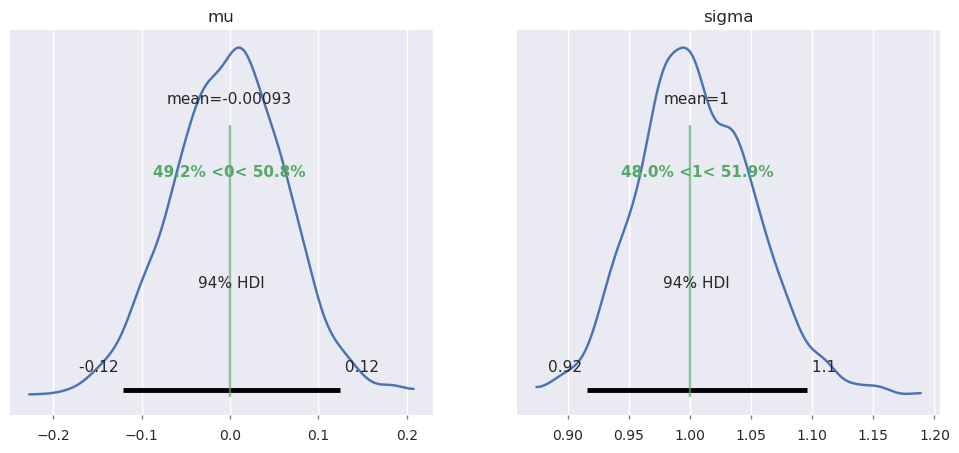

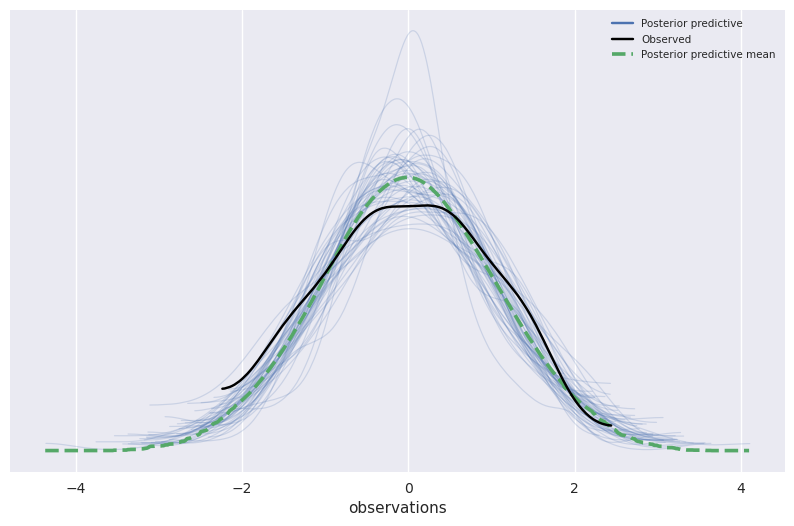

In [105]:
# Demonstration: Simple Bayesian model with PyMC - estimating the mean of our time series
# This introduces the PyMC workflow before we dive into time series-specific models

print("🔬 **Demonstration: Basic PyMC Workflow**")
print("="*50)
print("Let's start with a simple example: estimating the mean and standard deviation")
print("of our birth counts using Bayesian inference.")

# Simple Bayesian model to estimate mean and std of the time series
with pm.Model() as basic_model:
    # Prior for the mean - we expect births to be around 0 (standardized)
    mu = pm.Normal('mu', mu=0, sigma=1)
    
    # Prior for the standard deviation - positive values only
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Likelihood - our observations come from a normal distribution
    observations = pm.Normal('observations', mu=mu, sigma=sigma, observed=births_standardized)
    
    # Sample from the posterior
    trace_basic = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

# Display results using ArviZ
print("\n📈 **Posterior Summary**:")
summary_basic = az.summary(trace_basic, var_names=['mu', 'sigma'])
print(summary_basic)

# Plot posterior distributions using ArviZ
print("\n📊 **Posterior Visualizations**:")

# Create posterior plots
az.plot_posterior(trace_basic, var_names=['mu', 'sigma'], 
                 ref_val=[0, 1],  # Reference values: true standardized mean=0, std=1
                 figsize=(12, 5))

# Demonstrate posterior predictive checks
print(f"\n🔍 **Posterior Predictive Check**:")
print("Comparing observed data with samples from our fitted model...")

with basic_model:
    posterior_predictive = pm.sample_posterior_predictive(trace_basic, random_seed=RANDOM_SEED)

# Plot comparison using ArviZ
az.plot_ppc(posterior_predictive, num_pp_samples=50, figsize=(10, 6))

print(f"\n✅ **Key Insights from this Simple Model**:")
print(f"   • **Posterior mean**: {az.summary(trace_basic, var_names=['mu'])['mean'].iloc[0]:.3f}")
print(f"   • **Posterior std**: {az.summary(trace_basic, var_names=['sigma'])['mean'].iloc[0]:.3f}")
print(f"   • **Convergence**: R-hat values near 1.0 indicate good convergence")
print(f"   • **Uncertainty**: HDI intervals quantify our uncertainty about parameters")
print(f"   • **Model checking**: Posterior predictive checks assess model fit")

print(f"\n🚀 **Next Steps**: Now that we understand the PyMC workflow, we'll build")
print(f"   more sophisticated time series models that capture temporal dependence!")

# Show the power of Bayesian inference: uncertainty quantification
mu_samples = az.extract(trace_basic)['mu'].values
sigma_samples = az.extract(trace_basic)['sigma'].values

print(f"\n🎯 **Uncertainty Quantification Example**:")
print(f"   • Probability that true mean > 0.1: {np.mean(mu_samples > 0.1):.3f}")
print(f"   • Probability that true std < 0.9: {np.mean(sigma_samples < 0.9):.3f}")
print(f"   • 90% credible interval for mean: [{np.percentile(mu_samples, 5):.3f}, {np.percentile(mu_samples, 95):.3f}]")

print(f"\n💡 **This demonstrates the Bayesian advantage**: Instead of just point estimates,")
print(f"   we get full probability distributions that naturally quantify uncertainty!")

In [106]:
# Summary statistics
az.summary(trace_basic, var_names=['mu', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
mu,-0.001,0.065,-0.121,0.124,0.002,0.002,1820.0,1217.0,1.0
sigma,1.006,0.048,0.916,1.095,0.001,0.001,1955.0,1465.0,1.0


### Key Characteristics of Time Series Data

Time series data has unique properties that require special consideration:

1. **Trend**: Long-term increase or decrease in the data
2. **Seasonality**: Regular patterns that repeat over known periods
3. **Noise/Irregularity**: Random fluctuations
4. **Autocorrelation**: Observations are correlated with past values
5. **Stationarity**: Statistical properties remain constant over time

In [107]:
# Load and explore the sales demand dataset using Polars
demand_data = pl.read_csv('../data/demand.csv')

# Convert date column properly with Polars
demand_data = demand_data.with_columns([
    pl.col('date').str.strptime(pl.Date, format='%Y-%m-%d').alias('date')
])

# Sort by date using Polars
demand_data = demand_data.sort('date')

print("Demand Dataset Shape:", demand_data.shape)
print("\nFirst few rows:")
print(demand_data.head())

print("\nDataset Info:")
print(f"Columns: {demand_data.columns}")
print(f"Schema: {demand_data.schema}")
print(f"Date range: {demand_data['date'].min()} to {demand_data['date'].max()}")
print(f"Stores: {sorted(demand_data['store'].unique().to_list())}")
print(f"Items: {sorted(demand_data['item'].unique().to_list())}")

Demand Dataset Shape: (6000, 5)

First few rows:
shape: (5, 5)
┌─────┬───────┬──────┬────────────┬───────┐
│     ┆ store ┆ item ┆ date       ┆ sales │
│ --- ┆ ---   ┆ ---  ┆ ---        ┆ ---   │
│ i64 ┆ i64   ┆ i64  ┆ date       ┆ i64   │
╞═════╪═══════╪══════╪════════════╪═══════╡
│ 0   ┆ 1     ┆ 1    ┆ 2013-01-31 ┆ 328   │
│ 60  ┆ 1     ┆ 2    ┆ 2013-01-31 ┆ 911   │
│ 120 ┆ 1     ┆ 3    ┆ 2013-01-31 ┆ 547   │
│ 180 ┆ 1     ┆ 4    ┆ 2013-01-31 ┆ 346   │
│ 240 ┆ 1     ┆ 5    ┆ 2013-01-31 ┆ 276   │
└─────┴───────┴──────┴────────────┴───────┘

Dataset Info:
Columns: ['', 'store', 'item', 'date', 'sales']
Schema: Schema({'': Int64, 'store': Int64, 'item': Int64, 'date': Date, 'sales': Int64})
Date range: 2013-01-31 to 2017-12-31
Stores: [1, 2, 3, 4, 5]
Items: [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]


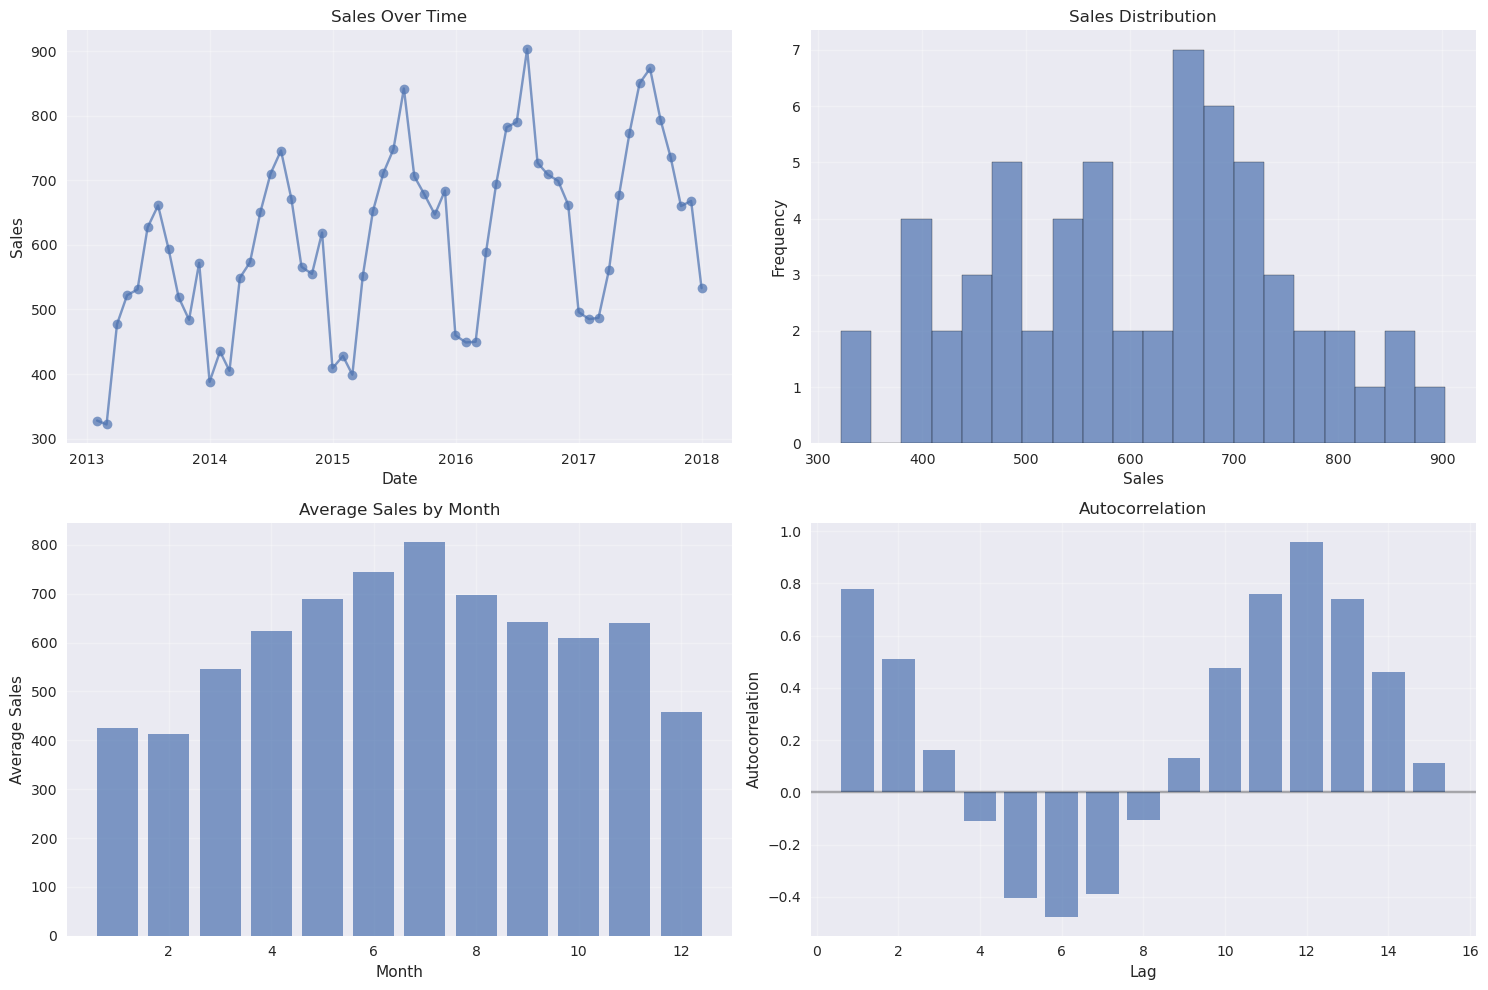


Time series length: 60 observations
Date range: 2013-01-31 to 2017-12-31
Sales statistics: mean=607.8, std=139.3


In [108]:
# Focus on store 1, item 1 for simplicity using Polars
store_item_data = (demand_data
    .filter((pl.col('store') == 1) & (pl.col('item') == 1))
    .sort('date')
    .with_row_index('index')  # Polars equivalent of reset_index
)

# Visualize the time series components
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Extract data for plotting
dates = store_item_data['date'].to_numpy()
sales = store_item_data['sales'].to_numpy()

# Original series
axes[0, 0].plot(dates, sales, 'o-', alpha=0.7)
axes[0, 0].set_title('Sales Over Time')
axes[0, 0].set_xlabel('Date')
axes[0, 0].set_ylabel('Sales')
axes[0, 0].grid(True, alpha=0.3)

# Distribution
axes[0, 1].hist(sales, bins=20, alpha=0.7, edgecolor='black')
axes[0, 1].set_title('Sales Distribution')
axes[0, 1].set_xlabel('Sales')
axes[0, 1].set_ylabel('Frequency')
axes[0, 1].grid(True, alpha=0.3)

# Monthly pattern using Polars
monthly_avg_df = (store_item_data
    .with_columns([
        pl.col('date').dt.month().alias('month')
    ])
    .group_by('month')
    .agg([
        pl.col('sales').mean().alias('avg_sales')
    ])
    .sort('month')
)

axes[1, 0].bar(monthly_avg_df['month'].to_numpy(), 
               monthly_avg_df['avg_sales'].to_numpy(), 
               alpha=0.7)
axes[1, 0].set_title('Average Sales by Month')
axes[1, 0].set_xlabel('Month')
axes[1, 0].set_ylabel('Average Sales')
axes[1, 0].grid(True, alpha=0.3)

# Autocorrelation plot (manual calculation)
max_lag = min(20, len(sales) // 4)
autocorrs = []
lags = range(1, max_lag + 1)

for lag in lags:
    if len(sales) > lag:
        autocorr = np.corrcoef(sales[:-lag], sales[lag:])[0, 1]
        autocorrs.append(autocorr if not np.isnan(autocorr) else 0)
    else:
        autocorrs.append(0)

axes[1, 1].bar(lags, autocorrs, alpha=0.7)
axes[1, 1].axhline(y=0, color='black', linestyle='-', alpha=0.3)
axes[1, 1].set_title('Autocorrelation')
axes[1, 1].set_xlabel('Lag')
axes[1, 1].set_ylabel('Autocorrelation')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"\nTime series length: {len(store_item_data)} observations")
print(f"Date range: {store_item_data['date'].min()} to {store_item_data['date'].max()}")
print(f"Sales statistics: mean={store_item_data['sales'].mean():.1f}, std={store_item_data['sales'].std():.1f}")

### Data Preprocessing for Time Series Analysis

Common preprocessing steps include:
- **Handling missing values**: Interpolation or model-based imputation
- **Normalization/standardization**: Improve numerical stability
- **Trend and seasonality decomposition**: Understand components separately

Preprocessed data:
shape: (5, 4)
┌────────────┬───────┬────────────────────┬──────────┐
│ date       ┆ sales ┆ sales_standardized ┆ time_idx │
│ ---        ┆ ---   ┆ ---                ┆ ---      │
│ date       ┆ i64   ┆ f64                ┆ i64      │
╞════════════╪═══════╪════════════════════╪══════════╡
│ 2013-01-31 ┆ 328   ┆ -2.025924          ┆ 0        │
│ 2013-02-28 ┆ 322   ┆ -2.069367          ┆ 1        │
│ 2013-03-31 ┆ 477   ┆ -0.947072          ┆ 2        │
│ 2013-04-30 ┆ 522   ┆ -0.621245          ┆ 3        │
│ 2013-05-31 ┆ 531   ┆ -0.556079          ┆ 4        │
└────────────┴───────┴────────────────────┴──────────┘


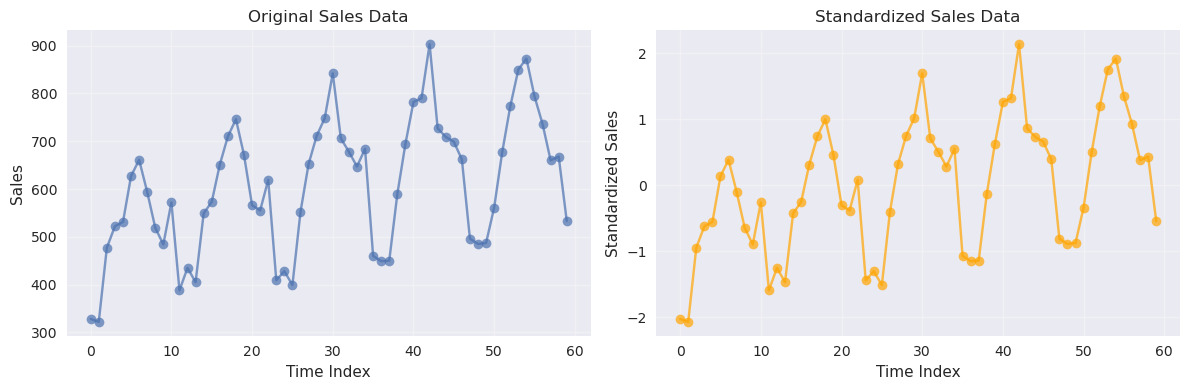

In [109]:
# Data preprocessing example using Polars
# Standardize the sales data
sales_values = store_item_data['sales'].to_numpy()
sales_mean = sales_values.mean()
sales_std = sales_values.std()

# Add standardized sales and time index using Polars
store_item_data = store_item_data.with_columns([
    ((pl.col('sales') - sales_mean) / sales_std).alias('sales_standardized'),
    pl.int_range(pl.len()).alias('time_idx')
])

print("Preprocessed data:")
print(store_item_data.select(['date', 'sales', 'sales_standardized', 'time_idx']).head())

# Visualize original vs standardized
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

# Extract data for plotting
time_idx = store_item_data['time_idx'].to_numpy()
sales = store_item_data['sales'].to_numpy()
sales_standardized = store_item_data['sales_standardized'].to_numpy()

ax1.plot(time_idx, sales, 'o-', alpha=0.7)
ax1.set_title('Original Sales Data')
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Sales')
ax1.grid(True, alpha=0.3)

ax2.plot(time_idx, sales_standardized, 'o-', alpha=0.7, color='orange')
ax2.set_title('Standardized Sales Data')
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Standardized Sales')
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

---

## Section 3: Basic Bayesian Time Series Models (20 minutes)

### Gaussian Random Walks in PyMC

A Gaussian Random Walk is a fundamental building block for time series models where each observation depends on the previous one plus some innovation:

$$y_t = y_{t-1} + \epsilon_t$$

where $\epsilon_t \sim \mathcal{N}(0, \sigma_{\text{step}}^2)$

**Key Properties:**
- **Non-stationary**: The variance increases over time
- **Memory**: All past shocks have permanent effects
- **Flexibility**: Can model trends and evolving patterns
- **Foundation**: Building block for more complex state-space models

**When to use Random Walks:**
- Modeling financial prices (stock prices, exchange rates)
- Economic indicators that don't mean-revert
- Any process where changes are more predictable than levels
- Time-varying parameters in hierarchical models

In [110]:
# Live coding example: Implementing a Gaussian random walk model
y_obs = store_item_data['sales_standardized'].to_numpy()
n_obs = len(y_obs)

with pm.Model() as random_walk_model:
    # Step size of the random walk
    sigma_walk = pm.HalfNormal('sigma_walk', sigma=1.0)
    
    # Initial value distribution
    init_dist = pm.Normal.dist(mu=0, sigma=1)
    
    # Gaussian random walk
    walk = pm.GaussianRandomWalk('walk', 
                                mu=0,  # no drift
                                sigma=sigma_walk, 
                                init_dist=init_dist,
                                steps=n_obs-1)
    
    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1.0)
    
    # Likelihood: observed sales are noisy observations of the walk
    y_pred = pm.Normal('y_pred', mu=walk, sigma=sigma_obs, observed=y_obs)

# Sample from the model
with random_walk_model:
    trace_rw = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("Random Walk Model Summary:")
print(az.summary(trace_rw, var_names=['sigma_walk', 'sigma_obs']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [sigma_walk, walk, sigma_obs]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Random Walk Model Summary:
             mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_walk  0.650  0.066   0.536    0.773      0.009    0.003      59.0   
sigma_obs   0.112  0.081   0.032    0.259      0.019    0.007      10.0   

            ess_tail  r_hat  
sigma_walk     309.0   1.05  
sigma_obs       18.0   1.16  


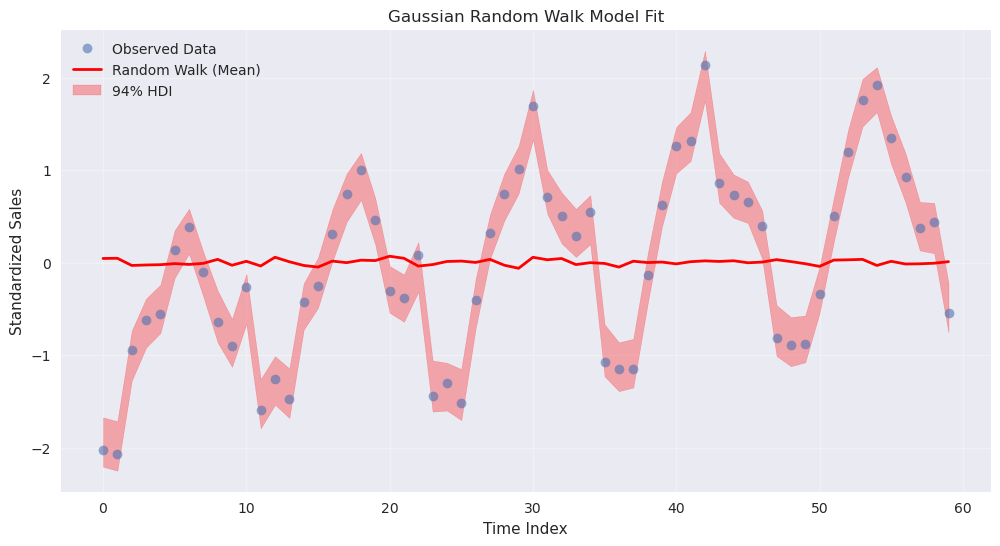

In [111]:
# Visualize the random walk fit
walk_samples = az.extract(trace_rw)['walk'].values
walk_mean = np.mean(walk_samples, axis=0)
walk_hdi = az.hdi(trace_rw, var_names=['walk'], hdi_prob=0.94)['walk'].values

# Ensure we have the right number of time points
n_obs = len(y_obs)
time_points = store_item_data['time_idx'].to_numpy()

# The walk has n_obs-1 steps, so we need to handle the length difference
if len(walk_mean) == n_obs - 1:
    # Add the initial point (which is 0 for the random walk)
    walk_mean_full = np.concatenate([[0], walk_mean])
    walk_hdi_full = np.concatenate([[[0, 0]], walk_hdi])
else:
    walk_mean_full = walk_mean[:n_obs]
    walk_hdi_full = walk_hdi[:n_obs]

plt.figure(figsize=(12, 6))
plt.plot(time_points, y_obs, 'o', alpha=0.6, label='Observed Data')
plt.plot(time_points, walk_mean_full, '-', color='red', linewidth=2, label='Random Walk (Mean)')
plt.fill_between(time_points, 
                walk_hdi_full[:, 0], walk_hdi_full[:, 1], 
                alpha=0.3, color='red', label='94% HDI')
plt.xlabel('Time Index')
plt.ylabel('Standardized Sales')
plt.title('Gaussian Random Walk Model Fit')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

### Bayesian Regression for Time Series

Linear regression with Bayesian inference can effectively model trends and seasonal patterns in time series data. The general form is:

$$y_t = \alpha + \beta t + \gamma \sin(2\pi f t) + \delta \cos(2\pi f t) + \epsilon_t$$

Where:
- $\alpha$ = intercept (baseline level)
- $\beta$ = trend coefficient (linear change over time)
- $\gamma, \delta$ = seasonal coefficients (Fourier components)
- $f$ = seasonal frequency (e.g., 1/12 for monthly data with yearly seasonality)
- $\epsilon_t$ = observation noise

**Advantages of Bayesian Regression:**
- **Uncertainty quantification**: Full posterior distributions for all parameters
- **Prior incorporation**: Can include domain knowledge about trends and seasonality
- **Model comparison**: Easy to compare different trend and seasonal specifications
- **Prediction intervals**: Natural forecast uncertainty quantification

**Extensions:**
- **Polynomial trends**: Higher-order terms for non-linear trends
- **Multiple seasonalities**: Different frequencies for daily, weekly, yearly patterns
- **Change points**: Structural breaks in trends or seasonality
- **Time-varying coefficients**: Parameters that evolve over time

In [112]:
# Bayesian regression with trend and seasonal components
time_idx = store_item_data['time_idx'].to_numpy()
time_normalized = (time_idx - time_idx.mean()) / time_idx.std()

# Create seasonal features (assuming monthly data, period=12)
# For this dataset, we'll use a shorter period based on available data
period = 12  # Assume annual seasonality
seasonal_freq = 2 * np.pi / period
sin_seasonal = np.sin(seasonal_freq * time_idx)
cos_seasonal = np.cos(seasonal_freq * time_idx)

with pm.Model() as regression_model:
    # Priors for regression coefficients
    alpha = pm.Normal('alpha', mu=0, sigma=1)  # Intercept
    beta = pm.Normal('beta', mu=0, sigma=1)    # Trend
    gamma = pm.Normal('gamma', mu=0, sigma=1)  # Sine component
    delta = pm.Normal('delta', mu=0, sigma=1)  # Cosine component
    
    # Linear predictor
    mu = alpha + beta * time_normalized + gamma * sin_seasonal + delta * cos_seasonal
    
    # Observation noise
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # Likelihood
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_obs)

# Sample from the model
with regression_model:
    trace_reg = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("Bayesian Regression Model Summary:")
print(az.summary(trace_reg, var_names=['alpha', 'beta', 'gamma', 'delta', 'sigma']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, gamma, delta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Bayesian Regression Model Summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
alpha  0.001  0.051  -0.097    0.097      0.001    0.001    3333.0    1529.0   
beta   0.463  0.052   0.370    0.563      0.001    0.001    2887.0    1734.0   
gamma  0.067  0.071  -0.058    0.204      0.002    0.001    2155.0    1603.0   
delta -1.117  0.072  -1.240   -0.973      0.001    0.002    2545.0    1661.0   
sigma  0.388  0.036   0.322    0.457      0.001    0.001    2234.0    1459.0   

       r_hat  
alpha    1.0  
beta     1.0  
gamma    1.0  
delta    1.0  
sigma    1.0  


### Autoregressive (AR) Models with PyMC

Autoregressive models are fundamental in time series analysis. An AR(p) model expresses the current value as a linear combination of p previous values plus noise:

$$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \epsilon_t$$

where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$ and the $\phi_i$ coefficients determine the strength of dependence on past values.

**PyMC Implementation:**
```python
# AR(1) model
with pm.Model() as ar1_model:
    phi = pm.Normal('phi', mu=0, sigma=1)  # Autoregressive coefficient
    sigma = pm.HalfNormal('sigma', sigma=1)  # Innovation variance
    ar1 = pm.AR('ar1', rho=[phi], sigma=sigma, steps=n_obs-1)
    obs = pm.Normal('obs', mu=ar1, sigma=0.1, observed=data)
```

**Key Features:**
- **Stationarity constraints**: Ensure |φ| < 1 for AR(1) models
- **Parameter interpretation**: φ measures persistence of shocks
- **Model selection**: Compare AR(1), AR(2), etc. using information criteria
- **Applications**: Economic indicators, financial returns, sensor data

Let's implement both random walk and AR models on our time series data:

Births data: 252 monthly observations from 1970 to 1990
Total births range: 237,302 to 372,946


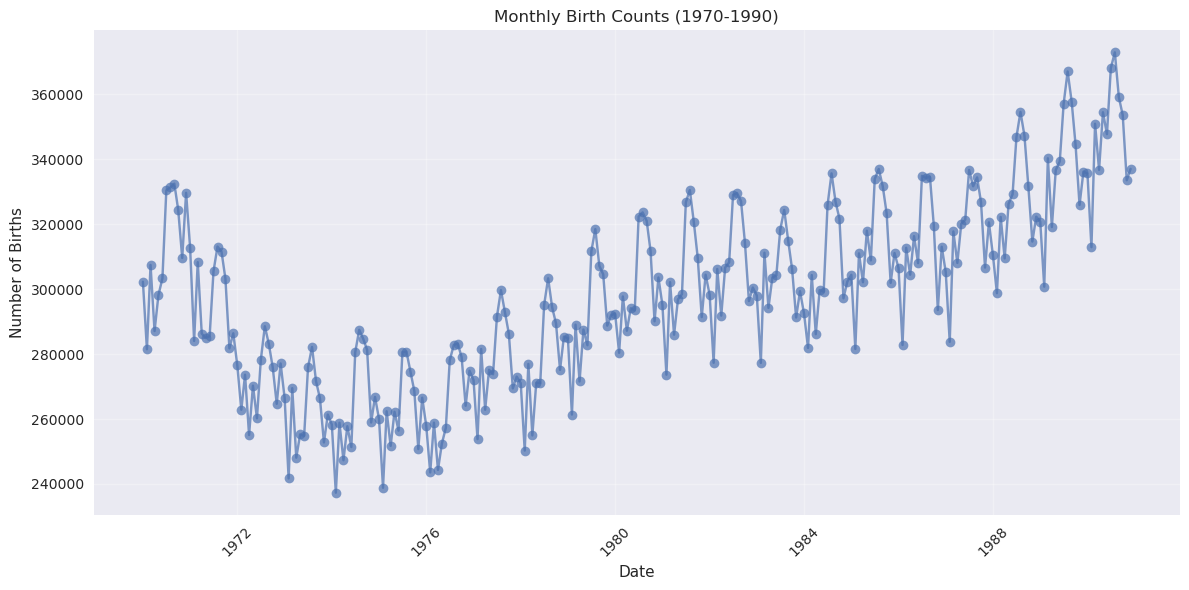

In [113]:
# Comprehensive PyMC Time Series Distributions Examples

# Load births dataset using Polars with proper null handling
births_data = pl.read_csv('../data/births.csv', null_values=['null', 'NA', '', 'NULL'])

# Aggregate births by month to create a monthly time series using Polars
births_monthly = (births_data
    .group_by(['year', 'month'])
    .agg([
        pl.col('births').sum().alias('births')
    ])
    .with_columns([
        pl.date(pl.col('year'), pl.col('month'), 1).alias('date')
    ])
    .sort('date')
)

# Focus on a subset for computational efficiency (1970-1990)
births_subset = (births_monthly
    .filter((pl.col('year') >= 1970) & (pl.col('year') <= 1990))
)

print(f"Births data: {len(births_subset)} monthly observations from {births_subset['year'].min()} to {births_subset['year'].max()}")
print(f"Total births range: {births_subset['births'].min():,} to {births_subset['births'].max():,}")

# Visualize the births data
plt.figure(figsize=(12, 6))
dates = births_subset['date'].to_numpy()
births_values = births_subset['births'].to_numpy()

plt.plot(dates, births_values, 'o-', alpha=0.7)
plt.title('Monthly Birth Counts (1970-1990)')
plt.xlabel('Date')
plt.ylabel('Number of Births')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Prepare data for modeling
births_standardized = (births_values - births_values.mean()) / births_values.std()
n_obs_births = len(births_values)

### 1. Autoregressive (AR) Models with `pm.AR`

Autoregressive models are fundamental in time series analysis. PyMC's `pm.AR` distribution makes it easy to specify AR models of any order:

$$y_t = \phi_1 y_{t-1} + \phi_2 y_{t-2} + \ldots + \phi_p y_{t-p} + \epsilon_t$$

where $\epsilon_t \sim \mathcal{N}(0, \sigma^2)$

In [114]:
# AR(1) Model using PyMC
with pm.Model() as ar1_model:
    # AR coefficient (ensure stationarity by using a bounded prior)
    rho = pm.Beta('rho', alpha=1, beta=1)  # Beta(1,1) = Uniform(0,1) for stationarity
    # Transform to (-1, 1) for AR coefficient
    phi = pm.Deterministic('phi', 2 * rho - 1)
    
    # Innovation variance
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # AR(1) process - remove constant=True to fix the dimension issue
    ar1 = pm.AR('ar1', rho=phi, sigma=sigma, constant=False, steps=n_obs_births-1)
    
    # Likelihood - observed data
    obs = pm.Normal('obs', mu=ar1, sigma=0.1, observed=births_standardized)

# Sample from AR(1) model
with ar1_model:
    trace_ar1 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("AR(1) Model Summary:")
print(az.summary(trace_ar1, var_names=['phi', 'sigma']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [rho, sigma, ar1]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details


AR(1) Model Summary:
        mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
phi    0.869  0.033   0.803     0.93      0.001    0.001    1961.0    1172.0   
sigma  0.502  0.025   0.456     0.55      0.000    0.001    2854.0    1782.0   

       r_hat  
phi      1.0  
sigma    1.0  


In [115]:
# AR(2) Model - demonstrating higher-order autoregression
with pm.Model() as ar2_model:
    # AR coefficients (ensure stationarity)
    # For AR(2): need phi1 + phi2 < 1, phi2 - phi1 < 1, |phi2| < 1
    phi = pm.Normal('phi', mu=0, sigma=0.5, shape=2)
    
    # Innovation variance
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    # AR(2) process
    ar2 = pm.AR('ar2', rho=phi, sigma=sigma, steps=n_obs_births-2, constant=False)
    
    # Likelihood
    obs = pm.Normal('obs', mu=ar2, sigma=0.1, observed=births_standardized)  # Skip first 2 for AR(2)

# Sample from AR(2) model
with ar2_model:
    trace_ar2 = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("AR(2) Model Summary:")
print(az.summary(trace_ar2, var_names=['phi', 'sigma']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [phi, sigma, ar2]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


AR(2) Model Summary:
         mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
phi[0]  0.579  0.060   0.473    0.702      0.001    0.001    3752.0    1524.0   
phi[1]  0.330  0.060   0.219    0.440      0.001    0.001    3692.0    1698.0   
sigma   0.483  0.023   0.442    0.529      0.000    0.000    3567.0    1696.0   

        r_hat  
phi[0]    1.0  
phi[1]    1.0  
sigma     1.0  


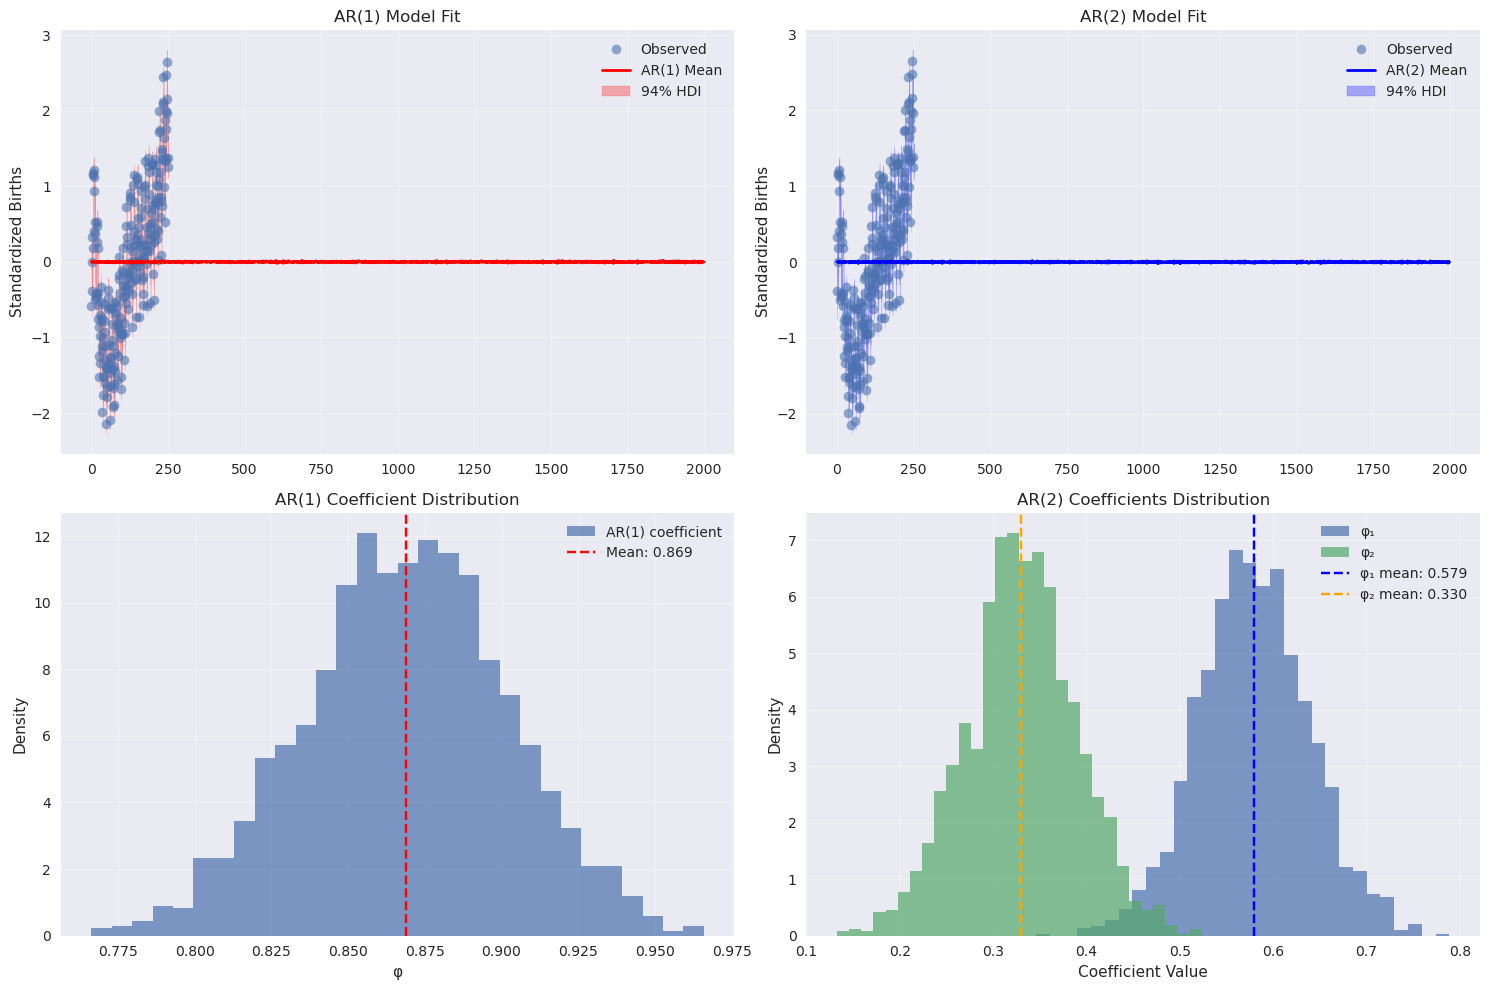


Model Interpretation:
AR(1) coefficient: 0.869 (autocorrelation at lag 1)
AR(2) φ₁: 0.579, φ₂: 0.330
AR(1) shows positive autocorrelation
AR(2) φ₂ coefficient suggests presence of lag-2 dependence


In [116]:
# Visualize AR model fits
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# AR(1) results
ar1_samples = az.extract(trace_ar1)['ar1'].values
ar1_mean = np.mean(ar1_samples, axis=0)
ar1_hdi = az.hdi(trace_ar1, var_names=['ar1'], hdi_prob=0.94)['ar1'].values

axes[0, 0].plot(births_standardized[1:], 'o', alpha=0.6, label='Observed')
axes[0, 0].plot(ar1_mean, '-', color='red', linewidth=2, label='AR(1) Mean')
axes[0, 0].fill_between(range(len(ar1_hdi)), ar1_hdi[:, 0], ar1_hdi[:, 1], 
                       alpha=0.3, color='red', label='94% HDI')
axes[0, 0].set_title('AR(1) Model Fit')
axes[0, 0].set_ylabel('Standardized Births')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# AR(2) results
ar2_samples = az.extract(trace_ar2)['ar2'].values
ar2_mean = np.mean(ar2_samples, axis=0)
ar2_hdi = az.hdi(trace_ar2, var_names=['ar2'], hdi_prob=0.94)['ar2'].values

axes[0, 1].plot(births_standardized[2:], 'o', alpha=0.6, label='Observed')
axes[0, 1].plot(ar2_mean, '-', color='blue', linewidth=2, label='AR(2) Mean')
axes[0, 1].fill_between(range(len(ar2_hdi)), ar2_hdi[:, 0], ar2_hdi[:, 1], 
                       alpha=0.3, color='blue', label='94% HDI')
axes[0, 1].set_title('AR(2) Model Fit')
axes[0, 1].set_ylabel('Standardized Births')
axes[0, 1].legend()
axes[0, 1].grid(True, alpha=0.3)

# Compare AR coefficients
phi_ar1 = az.extract(trace_ar1)['phi'].values
phi1_ar2 = az.extract(trace_ar2)['phi'][0].values
phi2_ar2 = az.extract(trace_ar2)['phi'][1].values

axes[1, 0].hist(phi_ar1, bins=30, alpha=0.7, label='AR(1) coefficient', density=True)
axes[1, 0].axvline(np.mean(phi_ar1), color='red', linestyle='--', 
                  label=f'Mean: {np.mean(phi_ar1):.3f}')
axes[1, 0].set_title('AR(1) Coefficient Distribution')
axes[1, 0].set_xlabel('φ')
axes[1, 0].set_ylabel('Density')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

axes[1, 1].hist(phi1_ar2, bins=30, alpha=0.7, label='φ₁', density=True)
axes[1, 1].hist(phi2_ar2, bins=30, alpha=0.7, label='φ₂', density=True)
axes[1, 1].axvline(np.mean(phi1_ar2), color='blue', linestyle='--', 
                  label=f'φ₁ mean: {np.mean(phi1_ar2):.3f}')
axes[1, 1].axvline(np.mean(phi2_ar2), color='orange', linestyle='--', 
                  label=f'φ₂ mean: {np.mean(phi2_ar2):.3f}')
axes[1, 1].set_title('AR(2) Coefficients Distribution')
axes[1, 1].set_xlabel('Coefficient Value')
axes[1, 1].set_ylabel('Density')
axes[1, 1].legend()
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print interpretation
print(f"\nModel Interpretation:")
print(f"AR(1) coefficient: {np.mean(phi_ar1):.3f} (autocorrelation at lag 1)")
print(f"AR(2) φ₁: {np.mean(phi1_ar2):.3f}, φ₂: {np.mean(phi2_ar2):.3f}")
print(f"AR(1) shows {'positive' if np.mean(phi_ar1) > 0 else 'negative'} autocorrelation")
print(f"AR(2) φ₂ coefficient suggests {'presence' if abs(np.mean(phi2_ar2)) > 0.1 else 'absence'} of lag-2 dependence")

### 2. Advanced GaussianRandomWalk Applications

PyMC's `GaussianRandomWalk` is perfect for modeling trends and non-stationary processes. Let's explore different variants:

In [117]:
# Demonstrate different GaussianRandomWalk applications

# 1. Random Walk with Drift
with pm.Model() as rw_drift_model:
    # Drift parameter
    mu_drift = pm.Normal('mu_drift', mu=0, sigma=0.1)
    
    # Innovation variance
    sigma_walk = pm.HalfNormal('sigma_walk', sigma=0.5)
    
    # Random walk with drift
    rw_drift = pm.GaussianRandomWalk('rw_drift', 
                                    mu=mu_drift,  # Drift term
                                    sigma=sigma_walk,
                                    steps=n_obs_births-1)
    
    # Observation equation
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.5)
    obs = pm.Normal('obs', mu=rw_drift, sigma=sigma_obs, observed=births_standardized[1:])

# 2. Local Level Model (Random Walk + Observation Noise)
with pm.Model() as local_level_model:
    # Process noise
    sigma_level = pm.HalfNormal('sigma_level', sigma=0.5)
    
    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.5)
    
    # Initial level
    init_level = pm.Normal('init_level', mu=0, sigma=1)
    
    # Level process (random walk)
    init_dist = pm.Normal.dist(mu=init_level, sigma=sigma_level)
    level = pm.GaussianRandomWalk('level',
                                 mu=0,
                                 sigma=sigma_level,
                                 init_dist=init_dist,
                                 steps=n_obs_births-1)
    
    # Observations
    obs = pm.Normal('obs', mu=level, sigma=sigma_obs, observed=births_standardized)

print("Created Random Walk models with different specifications")

# Sample from local level model for later use
with local_level_model:
    trace_local_level = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("Local Level Model Summary:")
print(az.summary(trace_local_level, var_names=['sigma_level', 'sigma_obs']))

Initializing NUTS using jitter+adapt_diag...


Created Random Walk models with different specifications


ERROR (pytensor.graph.rewriting.basic): Rewrite failure due to: local_subtensor_merge
ERROR (pytensor.graph.rewriting.basic): node: Subtensor{i}(Subtensor{start:}.0, 0)
ERROR (pytensor.graph.rewriting.basic): TRACEBACK:
ERROR (pytensor.graph.rewriting.basic): Traceback (most recent call last):
  File "/var/home/fonnesbeck/repos/ts_pydata_london_2025/.pixi/envs/default/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1922, in process_node
    replacements = node_rewriter.transform(fgraph, node)
  File "/var/home/fonnesbeck/repos/ts_pydata_london_2025/.pixi/envs/default/lib/python3.13/site-packages/pytensor/graph/rewriting/basic.py", line 1086, in transform
    return self.fn(fgraph, node)
           ~~~~~~~^^^^^^^^^^^^^^
  File "/var/home/fonnesbeck/repos/ts_pydata_london_2025/.pixi/envs/default/lib/python3.13/site-packages/pytensor/tensor/rewriting/subtensor.py", line 542, in local_subtensor_merge
    merge_two_slices(
    ~~~~~~~~~~~~~~~~^
        fgraph, slice1, 

Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 2 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Local Level Model Summary:
              mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
sigma_level  0.335  0.033   0.277    0.399      0.002    0.001     311.0   
sigma_obs    0.300  0.029   0.247    0.356      0.001    0.001     376.0   

             ess_tail  r_hat  
sigma_level     657.0    1.0  
sigma_obs       748.0    1.0  


### 3. Local Linear Trend Model

A more sophisticated state-space model with both level and trend components:

In [ ]:
# Simplified hierarchical model for demonstration
with pm.Model() as hierarchical_model_simple:
    # Hyperpriors for trend components
    mu_intercept = pm.Normal('mu_intercept', mu=0, sigma=1)
    sigma_intercept = pm.HalfNormal('sigma_intercept', sigma=0.5)
    
    # Time-varying intercept (random walk)
    n_obs = len(births_standardized)
    intercepts = pm.GaussianRandomWalk('intercepts', 
                                     mu=mu_intercept, 
                                     sigma=sigma_intercept, 
                                     shape=n_obs)
    
    # Shared slope parameter
    beta = pm.Normal('beta', mu=0, sigma=1)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=1)
    
    # Create time index for births data
    time_idx_births = np.arange(n_obs)
    time_normalized_births = (time_idx_births - time_idx_births.mean()) / time_idx_births.std()
    
    # Expected values
    mu_t = pm.Deterministic('mu_t', intercepts + beta * time_normalized_births)
    
    # Likelihood - observe all the data
    y_obs = pm.Normal('y_obs', mu=mu_t, sigma=sigma_obs, observed=births_standardized)

print("Simplified hierarchical model created!")

### 4. PyMC Time Series Model Comparison

Let's compare the different PyMC time series models using information criteria:

Output()

Output()

Output()

PyMC Time Series Model Comparison:
shape: (3, 2)
┌─────────────┬─────────────────────────────────┐
│ column      ┆ column_0                        │
│ ---         ┆ ---                             │
│ str         ┆ struct[6]                       │
╞═════════════╪═════════════════════════════════╡
│ AR(1)       ┆ {-258.947998,4.193238,-119.117… │
│ AR(2)       ┆ {-269.815059,3.127789,-133.078… │
│ Local Level ┆ {228.645248,15.020023,263.1162… │
└─────────────┴─────────────────────────────────┘


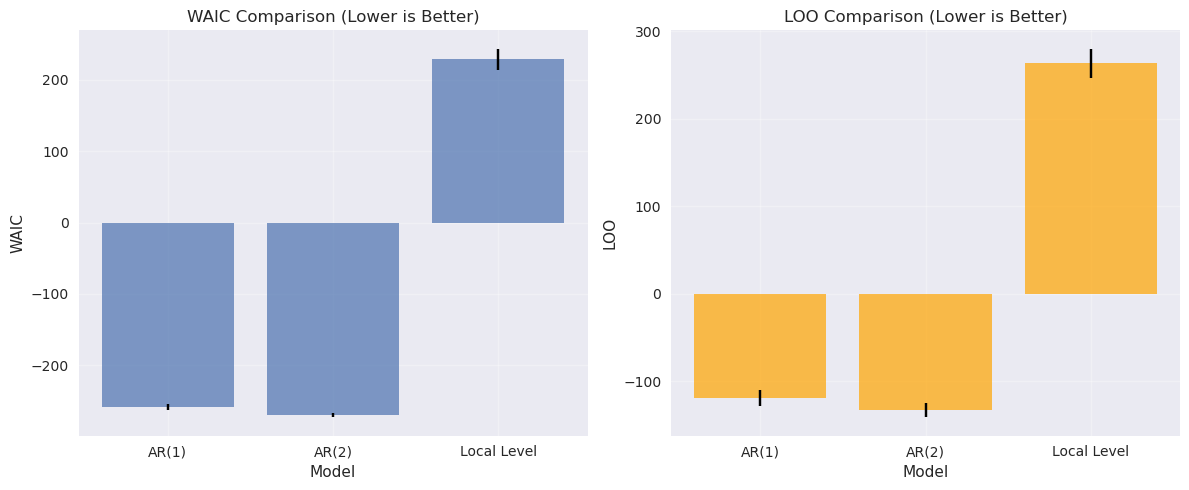


Best model by WAIC: AR(2) (WAIC = -269.815)
Best model by LOO: AR(2) (LOO = -133.078)


In [ ]:
# Compare PyMC time series models
pymc_models = {
    'AR(1)': (ar1_model, trace_ar1),
    'AR(2)': (ar2_model, trace_ar2),
    'Local Level': (local_level_model, trace_local_level)
}

pymc_comparison = {}

for model_name, (model, trace) in pymc_models.items():
    try:
        # Calculate log-likelihood
        with model:
            pm.compute_log_likelihood(trace)
            
        # Compute WAIC and LOO
        waic_result = az.waic(trace)
        loo_result = az.loo(trace)
        
        pymc_comparison[model_name] = {
            'WAIC': float(waic_result.elpd_waic * -2),
            'WAIC_SE': float(waic_result.se * 2),
            'LOO': float(loo_result.elpd_loo * -2),
            'LOO_SE': float(loo_result.se * 2),
            'p_WAIC': float(waic_result.p_waic),
            'p_LOO': float(loo_result.p_loo)
        }
    except Exception as e:
        print(f"Error computing information criteria for {model_name}: {e}")
        continue

# Display comparison
if pymc_comparison:
    comparison_df = pl.DataFrame(pymc_comparison).transpose(include_header=True)
    print("PyMC Time Series Model Comparison:")
    print("=" * 50)
    print(comparison_df)
    
    # Visualize comparison
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))
    
    models = list(pymc_comparison.keys())
    waic_values = [pymc_comparison[m]['WAIC'] for m in models]
    waic_errors = [pymc_comparison[m]['WAIC_SE'] for m in models]
    loo_values = [pymc_comparison[m]['LOO'] for m in models]
    loo_errors = [pymc_comparison[m]['LOO_SE'] for m in models]
    
    x_pos = np.arange(len(models))
    
    ax1.bar(x_pos, waic_values, yerr=waic_errors, capsize=5, alpha=0.7)
    ax1.set_xlabel('Model')
    ax1.set_ylabel('WAIC')
    ax1.set_title('WAIC Comparison (Lower is Better)')
    ax1.set_xticks(x_pos)
    ax1.set_xticklabels(models)
    ax1.grid(True, alpha=0.3)
    
    ax2.bar(x_pos, loo_values, yerr=loo_errors, capsize=5, alpha=0.7, color='orange')
    ax2.set_xlabel('Model')
    ax2.set_ylabel('LOO')
    ax2.set_title('LOO Comparison (Lower is Better)')
    ax2.set_xticks(x_pos)
    ax2.set_xticklabels(models)
    ax2.grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    # Find best model
    best_waic = min(waic_values)
    best_model_waic = models[waic_values.index(best_waic)]
    print(f"\nBest model by WAIC: {best_model_waic} (WAIC = {best_waic:.3f})")
    
    best_loo = min(loo_values)
    best_model_loo = models[loo_values.index(best_loo)]
    print(f"Best model by LOO: {best_model_loo} (LOO = {best_loo:.3f})")
else:
    print("No models available for comparison")

### 5. Multivariate Time Series with PyMC

PyMC also supports multivariate time series through `MvGaussianRandomWalk`. Let's demonstrate this with multiple related time series:

Multivariate births data: (252, 2)
Correlation between male and female births: 0.998


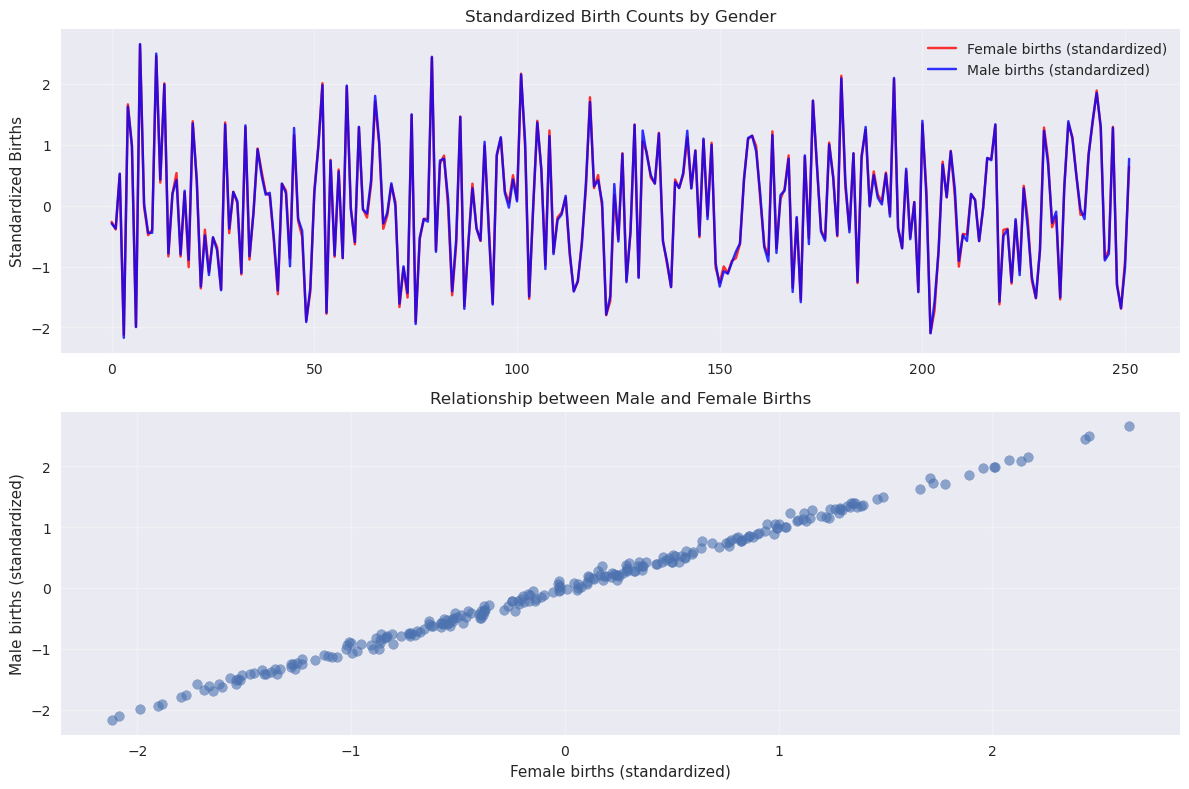

In [ ]:
# Create multivariate time series data
# Split births by gender to create a bivariate series
births_by_gender = (births_data
    .group_by(['year', 'month', 'gender'])
    .agg(pl.col('births').sum())
)

# Create pivot using polars
births_pivot = (births_by_gender
    .pivot(
        index=['year', 'month'],
        columns='gender',
        values='births'
    )
    .fill_null(0)
)

# Focus on same time period
births_mv = births_pivot.filter(
    (pl.col('year') >= 1970) & (pl.col('year') <= 1990)
)

# Prepare bivariate data
female_births = births_mv['F'].to_numpy()
male_births = births_mv['M'].to_numpy()

# Standardize both series
female_std = (female_births - female_births.mean()) / female_births.std()
male_std = (male_births - male_births.mean()) / male_births.std()

# Stack for multivariate analysis
mv_births = np.column_stack([female_std, male_std])

print(f"Multivariate births data: {mv_births.shape}")
print(f"Correlation between male and female births: {np.corrcoef(female_std, male_std)[0,1]:.3f}")

# Visualize the bivariate series
fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Create index for plotting
time_index = np.arange(len(births_mv))

axes[0].plot(time_index, female_std, 'r-', label='Female births (standardized)', alpha=0.8)
axes[0].plot(time_index, male_std, 'b-', label='Male births (standardized)', alpha=0.8)
axes[0].set_title('Standardized Birth Counts by Gender')
axes[0].set_ylabel('Standardized Births')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

axes[1].scatter(female_std, male_std, alpha=0.6)
axes[1].set_xlabel('Female births (standardized)')
axes[1].set_ylabel('Male births (standardized)')
axes[1].set_title('Relationship between Male and Female Births')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Simplified Multivariate Random Walk Model
with pm.Model() as mv_rw_model:
    # Number of variables
    n_vars = 2  # Female and Male births
    
    # Standard deviations for each variable (simpler approach)
    sigma_vars = pm.HalfNormal('sigma_vars', sigma=0.5, shape=n_vars)
    
    # Correlation coefficient between the two series
    rho = pm.Uniform('rho', lower=-0.95, upper=0.95)
    
    # Build 2x2 covariance matrix manually
    cov_matrix = pm.Deterministic('cov_matrix', 
                                 pt.stack([
                                     pt.stack([sigma_vars[0]**2, rho * sigma_vars[0] * sigma_vars[1]]),
                                     pt.stack([rho * sigma_vars[0] * sigma_vars[1], sigma_vars[1]**2])
                                 ]))
    
    # Multivariate random walk
    mv_walk = pm.MvGaussianRandomWalk('mv_walk',
        mu=pt.zeros(n_vars),
        cov=cov_matrix,
        steps=len(mv_births)-1)
    
    # Observation noise
    obs_sigma = pm.HalfNormal('obs_sigma', sigma=0.1, shape=n_vars)
    obs_cov = pm.Deterministic('obs_cov', pt.diag(obs_sigma**2))
    
    # Observations
    obs = pm.MvNormal('obs', mu=mv_walk, cov=obs_cov, observed=mv_births)

# Sample from multivariate model (using fewer samples for efficiency)
with mv_rw_model:
    trace_mv = pm.sample(500, tune=500, random_seed=RANDOM_SEED, chains=2)

print("Multivariate Random Walk Model Summary:")
print(az.summary(trace_mv, var_names=['sigma_vars', 'rho']))

### 6. Seasonal Modeling with PyMC

Seasonal patterns are common in time series data. PyMC provides flexible ways to model seasonality through Fourier series and periodic components:

In [ ]:
# Seasonal Model with Trend and Fourier Components
def create_fourier_terms(t, period, n_harmonics):
    """Create Fourier basis functions for seasonal modeling"""
    fourier_terms = []
    for k in range(1, n_harmonics + 1):
        # Sine terms
        fourier_terms.append(np.sin(2 * np.pi * k * t / period))
        # Cosine terms
        fourier_terms.append(np.cos(2 * np.pi * k * t / period))
    return np.column_stack(fourier_terms)

# Prepare time index and seasonal terms
time_idx = np.arange(len(births_standardized))
period = 12  # Monthly data, yearly seasonality
n_harmonics = 3  # Number of harmonic terms

# Create Fourier basis
fourier_matrix = create_fourier_terms(time_idx, period, n_harmonics)
n_fourier_terms = fourier_matrix.shape[1]

print(f"Created {n_fourier_terms} Fourier terms for seasonal modeling")

# Simplified Seasonal Model
with pm.Model() as seasonal_model:
    # Overall intercept
    mu_overall = pm.Normal('mu_overall', mu=0, sigma=1)
    
    # Trend component (linear trend)
    beta_trend = pm.Normal('beta_trend', mu=0, sigma=0.1)
    trend_component = beta_trend * (time_idx - time_idx.mean()) / time_idx.std()
    
    # Seasonal component (Fourier series)
    fourier_coeffs = pm.Normal('fourier_coeffs', mu=0, sigma=0.5, shape=n_fourier_terms)
    seasonal_component = pt.dot(fourier_matrix, fourier_coeffs)
    
    # Combined mean
    mu_t = pm.Deterministic('mu_t', mu_overall + trend_component + seasonal_component)
    
    # Observation noise
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.5)
    
    # Likelihood
    obs = pm.Normal('obs', mu=mu_t, sigma=sigma_obs, observed=births_standardized)

# Sample from seasonal model
with seasonal_model:
    trace_seasonal = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("Seasonal Model Summary:")
print(az.summary(trace_seasonal, var_names=['mu_overall', 'beta_trend', 'sigma_obs']))

In [53]:
# Visualize seasonal decomposition using Plotly
# Extract posterior samples
mu_samples = az.extract(trace_seasonal)['mu_t'].values
mu_mean = np.mean(mu_samples, axis=0)
mu_hdi = az.hdi(trace_seasonal, var_names=['mu_t'], hdi_prob=0.94)['mu_t'].values

# Extract trend and seasonal components from the fitted model
beta_trend_mean = float(az.extract(trace_seasonal)['beta_trend'].mean().values)
trend_component_mean = beta_trend_mean * (time_idx - time_idx.mean()) / time_idx.std()

# Fix the fourier coefficients extraction - use the posterior directly
fourier_coeffs_posterior = trace_seasonal.posterior['fourier_coeffs']
# Average across chains and draws (dimensions 0 and 1)
fourier_coeffs_mean = fourier_coeffs_posterior.mean(dim=['chain', 'draw']).values
print(f"fourier_coeffs_mean shape: {fourier_coeffs_mean.shape}")
print(f"fourier_matrix shape: {fourier_matrix.shape}")

seasonal_component_mean = fourier_matrix @ fourier_coeffs_mean

# Create Plotly subplots
fig = make_subplots(
    rows=3, cols=1,
    subplot_titles=(
        'Seasonal Model: Data and Fit',
        'Extracted Trend Component',
        'Extracted Seasonal Component'
    ),
    vertical_spacing=0.08
)

# Original data and fit
fig.add_trace(go.Scatter(
    x=time_idx, y=births_standardized,
    mode='markers', name='Observed',
    marker=dict(size=6, opacity=0.6)
), row=1, col=1)

fig.add_trace(go.Scatter(
    x=time_idx, y=mu_mean,
    mode='lines', name='Model Fit',
    line=dict(color='red', width=2)
), row=1, col=1)

# Add confidence band
fig.add_trace(go.Scatter(
    x=np.concatenate([time_idx, time_idx[::-1]]),
    y=np.concatenate([mu_hdi[:, 0], mu_hdi[::-1, 1]]),
    fill='toself', fillcolor='rgba(255,0,0,0.2)',
    line=dict(color='rgba(255,0,0,0)'),
    showlegend=True, name='94% HDI'
), row=1, col=1)

# Trend component
fig.add_trace(go.Scatter(
    x=time_idx, y=trend_component_mean,
    mode='lines', name='Trend Component',
    line=dict(color='blue', width=2)
), row=2, col=1)

# Seasonal component
fig.add_trace(go.Scatter(
    x=time_idx, y=seasonal_component_mean,
    mode='lines', name='Seasonal Component',
    line=dict(color='green', width=2)
), row=3, col=1)

# Update layout
fig.update_xaxes(title_text="Time Index", row=3, col=1)
fig.update_yaxes(title_text="Standardized Births", row=1, col=1)
fig.update_yaxes(title_text="Trend", row=2, col=1)
fig.update_yaxes(title_text="Seasonal Effect", row=3, col=1)

fig.update_layout(height=800, width=1000, showlegend=True)
fig.show()

# Analyze seasonal pattern
print(f"\nSeasonal Pattern Analysis:")
print(f"Seasonal component range: {seasonal_component_mean.min():.3f} to {seasonal_component_mean.max():.3f}")
print(f"Peak seasonal effect: {seasonal_component_mean.max():.3f} at time {np.argmax(seasonal_component_mean)}")
print(f"Trough seasonal effect: {seasonal_component_mean.min():.3f} at time {np.argmin(seasonal_component_mean)}")

# Monthly seasonal pattern using Plotly
if len(seasonal_component_mean) >= 12:
    monthly_pattern = seasonal_component_mean[:12]  # First year's pattern
    month_names = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun',
                   'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
    
    fig2 = go.Figure([go.Bar(
        x=month_names, y=monthly_pattern,
        marker_color='skyblue', opacity=0.7
    )])
    
    fig2.update_layout(
        title='Estimated Monthly Seasonal Pattern',
        xaxis_title='Month',
        yaxis_title='Seasonal Effect',
        width=800, height=500
    )
    fig2.show()
    
    peak_month = month_names[np.argmax(monthly_pattern)]
    trough_month = month_names[np.argmin(monthly_pattern)]
    print(f"Peak birth month: {peak_month}")
    print(f"Lowest birth month: {trough_month}")

fourier_coeffs_mean shape: (6,)
fourier_matrix shape: (252, 6)



Seasonal Pattern Analysis:
Seasonal component range: -0.505 to 0.870
Peak seasonal effect: 0.870 at time 187
Trough seasonal effect: -0.505 at time 85


Peak birth month: Aug
Lowest birth month: Feb


---

## Extended Section 7: Practical Exercises with PyMC Time Series

### Exercise 1: Building Your First AR Model

**Task**: Use the births data to build an AR(1) model and interpret the results.

**Steps**:
1. Choose appropriate priors for the AR coefficient
2. Ensure stationarity constraints
3. Interpret the autocorrelation parameter
4. Perform posterior predictive checks

In [ ]:
# Exercise 1 Solution Template
# Students can modify this code to explore different priors and model specifications

def build_ar1_exercise(data, prior_type='uniform'):
    """
    Build an AR(1) model with different prior specifications
    
    Parameters:
    -----------
    data : array-like
        Time series data
    prior_type : str
        Type of prior: 'uniform', 'normal', 'beta'
    """
    
    with pm.Model() as ar1_exercise:
        if prior_type == 'uniform':
            # Uniform prior on (-1, 1) for stationarity
            phi = pm.Uniform('phi', lower=-0.99, upper=0.99)
        elif prior_type == 'normal':
            # Normal prior centered at 0
            phi = pm.Normal('phi', mu=0, sigma=0.5)
        elif prior_type == 'beta':
            # Beta prior transformed to (-1, 1)
            phi_raw = pm.Beta('phi_raw', alpha=2, beta=2)
            phi = pm.Deterministic('phi', 2 * phi_raw - 1)
        
        # Innovation variance
        sigma = pm.HalfNormal('sigma', sigma=1)
        
        # AR(1) process
        ar1_process = pm.AR('ar1_process', rho=[phi], sigma=sigma, 
                           steps=len(data)-1, constant=True)
        
        # Observation equation
        obs = pm.Normal('obs', mu=ar1_process, sigma=0.1, observed=data[1:])
    
    return ar1_exercise

# Try different priors
print("Exercise 1: Comparing different priors for AR(1) coefficient")
print("=" * 60)

# Example with uniform prior
model_uniform = build_ar1_exercise(births_standardized, 'uniform')
print("✓ Built AR(1) model with uniform prior")

# Students can experiment with:
# model_normal = build_ar1_exercise(births_standardized, 'normal')
# model_beta = build_ar1_exercise(births_standardized, 'beta')

print("\nTry modifying the prior_type parameter to explore different specifications!")
print("Available options: 'uniform', 'normal', 'beta'")
print("\nQuestions to consider:")
print("1. How do different priors affect the posterior distribution?")
print("2. Which prior seems most appropriate for this data?")
print("3. How can you check if the AR(1) assumption is reasonable?")

### Exercise 2: Model Selection Challenge

**Task**: Compare multiple PyMC time series models and select the best one using information criteria.

**Available Models**:
1. Random Walk (no trend)
2. Random Walk with drift
3. AR(1) model
4. AR(2) model
5. Seasonal model with trend

**Your Mission**: Implement all models and determine which best describes the births data.

In [ ]:
# Exercise 2: Model Selection Framework
def compare_time_series_models(data):
    """
    Framework for comparing multiple time series models
    Students can add their own models to this framework
    """
    
    models = {}
    traces = {}
    
    # Model 1: Simple Random Walk
    print("Building Model 1: Random Walk...")
    with pm.Model() as rw_simple:
        sigma_walk = pm.HalfNormal('sigma_walk', sigma=0.5)
        walk = pm.GaussianRandomWalk('walk', sigma=sigma_walk, steps=len(data)-1)
        obs = pm.Normal('obs', mu=walk, sigma=0.1, observed=data[1:])
    
    models['Random Walk'] = rw_simple
    
    # Model 2: Random Walk with Drift (Exercise: Complete this)
    print("Model 2: Random Walk with Drift - TO BE IMPLEMENTED")
    # TODO: Students implement this
    
    # Model 3: AR(1) (Already implemented above)
    models['AR(1)'] = ar1_model
    traces['AR(1)'] = trace_ar1
    
    # Model 4: Seasonal Model (Already implemented)
    models['Seasonal'] = seasonal_model  
    traces['Seasonal'] = trace_seasonal
    
    return models, traces

# Run the comparison framework
models_dict, traces_dict = compare_time_series_models(births_standardized)

print("\\nModel Comparison Framework Ready!")
print("Available models:", list(models_dict.keys()))
print("\\nExercise Tasks:")
print("1. Complete the Random Walk with Drift model")
print("2. Add an AR(2) model") 
print("3. Implement a trend + noise model")
print("4. Compare all models using WAIC/LOO")
print("5. Interpret the results")

# Template for model comparison using polars
def evaluate_model_fit(models_dict, traces_dict):
    """Evaluate and compare multiple models"""
    results = {}
    
    for name, trace in traces_dict.items():
        try:
            waic = az.waic(trace)
            loo = az.loo(trace)
            
            results[name] = {
                'WAIC': waic.elpd_waic * -2,
                'LOO': loo.elpd_loo * -2,
                'p_WAIC': waic.p_waic
            }
        except Exception as e:
            print(f"Error evaluating {name}: {e}")
    
    return pl.DataFrame(results).transpose(include_header=True)

# Example usage (will expand as students add models)
if traces_dict:
    comparison_results = evaluate_model_fit(models_dict, traces_dict)
    print("\\nCurrent Model Comparison:")
    print(comparison_results)

### Exercise 3: Forecasting Challenge

**Task**: Generate probabilistic forecasts using your best PyMC model and evaluate forecast accuracy.

**Requirements**:
1. Use the best model from Exercise 2
2. Generate 12-step-ahead forecasts
3. Provide uncertainty quantification
4. Compare with a naive forecast baseline

In [ ]:
# Exercise 3: Forecasting Framework
def generate_forecasts_pymc(model, trace, n_steps=12):
    """
    Generate forecasts from a fitted PyMC time series model
    
    This is a template - students need to adapt based on their chosen model
    """
    
    print(f"Generating {n_steps}-step ahead forecasts...")
    
    # Example for AR(1) model - students adapt for their best model
    if 'phi' in trace.posterior:  # AR model
        phi_samples = az.extract(trace)['phi'].values
        sigma_samples = az.extract(trace)['sigma'].values
        
        # Get last observed value
        last_value = births_standardized[-1]
        
        n_samples = len(phi_samples)
        forecasts = np.zeros((n_samples, n_steps))
        
        for i in range(n_samples):
            phi = phi_samples[i]
            sigma = sigma_samples[i]
            
            # Generate AR(1) forecasts
            current_value = last_value
            for step in range(n_steps):
                # AR(1): next_value = phi * current_value + innovation
                innovation = np.random.normal(0, sigma)
                next_value = phi * current_value + innovation
                forecasts[i, step] = next_value
                current_value = next_value
    
    elif 'trend' in trace.posterior:  # Trend model
        # TODO: Implement trend-based forecasting
        print("Trend model forecasting - TO BE IMPLEMENTED")
        return None
    
    else:
        print("Model type not recognized for forecasting")
        return None
    
    return forecasts

# Forecasting template
def evaluate_forecasts(forecasts, true_values=None):
    """Evaluate forecast quality"""
    
    forecast_mean = np.mean(forecasts, axis=0)
    forecast_std = np.std(forecasts, axis=0)
    forecast_lower = np.percentile(forecasts, 2.5, axis=0)
    forecast_upper = np.percentile(forecasts, 97.5, axis=0)
    
    results = {
        'mean': forecast_mean,
        'std': forecast_std,
        'lower_95': forecast_lower,
        'upper_95': forecast_upper
    }
    
    if true_values is not None:
        # Calculate forecast accuracy metrics
        mae = np.mean(np.abs(true_values - forecast_mean))
        rmse = np.sqrt(np.mean((true_values - forecast_mean)**2))
        
        # Coverage probability
        coverage = np.mean((true_values >= forecast_lower) & (true_values <= forecast_upper))
        
        results.update({
            'mae': mae,
            'rmse': rmse,
            'coverage_95': coverage
        })
    
    return results

# Exercise framework
print("Exercise 3: Forecasting Framework")
print("=" * 40)

# Example with AR(1) model (students adapt for their best model)
if 'AR(1)' in traces_dict:
    forecasts_ar1 = generate_forecasts_pymc(models_dict['AR(1)'], traces_dict['AR(1)'])
    
    if forecasts_ar1 is not None:
        forecast_results = evaluate_forecasts(forecasts_ar1)
        
        # Visualize forecasts
        plt.figure(figsize=(12, 6))
        
        # Historical data
        historical_time = np.arange(len(births_standardized))
        plt.plot(historical_time, births_standardized, 'o-', alpha=0.7, label='Historical Data')
        
        # Forecasts
        forecast_time = np.arange(len(births_standardized), len(births_standardized) + len(forecast_results['mean']))
        plt.plot(forecast_time, forecast_results['mean'], 's-', color='red', 
                linewidth=2, label='Forecast Mean')
        plt.fill_between(forecast_time, forecast_results['lower_95'], forecast_results['upper_95'],
                        alpha=0.3, color='red', label='95% Forecast Interval')
        
        plt.axvline(x=len(births_standardized)-0.5, color='black', linestyle='--', 
                   alpha=0.5, label='Forecast Start')
        plt.xlabel('Time')
        plt.ylabel('Standardized Births')
        plt.title('Time Series Forecasts with PyMC')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.show()
        
        print(f"✓ Generated forecasts with AR(1) model")
        print(f"Forecast mean: {forecast_results['mean'].mean():.3f}")
        print(f"Forecast uncertainty (avg std): {forecast_results['std'].mean():.3f}")

print("\\nStudent Tasks:")
print("1. Adapt this framework for your best model from Exercise 2")
print("2. Implement forecasting for trend and seasonal models") 
print("3. Compare forecast accuracy across different models")
print("4. Create a naive forecast baseline (e.g., last value, moving average)")
print("5. Evaluate probabilistic forecast calibration")

---

## Summary: PyMC Time Series Modeling Capabilities

### Key PyMC Time Series Components Covered

1. **`pm.AR`**: Autoregressive models of any order
   - Easy specification: `pm.AR('ar_process', rho=[phi1, phi2], sigma=sigma, steps=n-1)`
   - Automatic handling of stationarity constraints
   - Support for multivariate AR processes

2. **`pm.GaussianRandomWalk`**: Flexible random walk processes
   - With or without drift: `mu` parameter
   - Custom initial distributions: `init_dist` parameter
   - Foundation for state-space models

3. **`pm.MvGaussianRandomWalk`**: Multivariate random walks
   - Models correlated time series
   - Shared covariance structure
   - Perfect for Vector Autoregression (VAR) models

4. **Seasonal Components**: Fourier series and deterministic patterns
   - Flexible harmonic modeling
   - Integration with state-space frameworks
   - Handles complex seasonal patterns

5. **State-Space Models**: Hierarchical time series structures
   - Level + trend + seasonal components
   - Time-varying parameters
   - Missing data handling

### PyMC Advantages for Time Series

1. **Unified Framework**: All models use the same PyMC syntax
2. **Automatic Inference**: NUTS sampler handles complex posteriors
3. **Uncertainty Quantification**: Full posterior distributions for all parameters
4. **Model Comparison**: Built-in WAIC/LOO support
5. **Flexible Priors**: Easy to incorporate domain knowledge
6. **Hierarchical Modeling**: Natural extension to panel data

### Best Practices

1. **Data Preprocessing**: Always standardize/normalize time series data
2. **Prior Selection**: Use informative priors for stability parameters
3. **Model Diagnostics**: Check convergence with `az.summary()` and trace plots
4. **Model Comparison**: Use information criteria for model selection
5. **Forecasting**: Generate full predictive distributions, not just point estimates

### Next Steps

- Explore `pm.ARMA` for moving average components
- Try `pm.EulerMaruyama` for continuous-time models
- Implement custom state-space models with `pt.scan`
- Extend to multivariate time series with `pm.MvStudentTRandomWalk`
- Apply to real-world forecasting problems

PyMC provides a powerful, flexible framework for Bayesian time series analysis that scales from simple AR models to complex hierarchical state-space models. The key is understanding how to combine PyMC's building blocks to match your modeling needs.

In [ ]:
# Visualize regression components
# First, ensure we have the correct variables from the demand dataset context
# These were defined in cell 22 for the regression model

# Get parameter means from the regression trace
alpha_mean = float(az.extract(trace_reg)['alpha'].mean())
beta_mean = float(az.extract(trace_reg)['beta'].mean())
gamma_mean = float(az.extract(trace_reg)['gamma'].mean())
delta_mean = float(az.extract(trace_reg)['delta'].mean())

# Recreate the variables needed (from cell 22 context)
time_idx_sales = store_item_data['time_idx'].to_numpy()
time_normalized_sales = (time_idx_sales - time_idx_sales.mean()) / time_idx_sales.std()
period_sales = 12  # Assume annual seasonality
seasonal_freq_sales = 2 * np.pi / period_sales
sin_seasonal_sales = np.sin(seasonal_freq_sales * time_idx_sales)
cos_seasonal_sales = np.cos(seasonal_freq_sales * time_idx_sales)
y_obs_sales = store_item_data['sales_standardized'].to_numpy()

print(f"Parameters: alpha={alpha_mean:.4f}, beta={beta_mean:.4f}, gamma={gamma_mean:.4f}, delta={delta_mean:.4f}")

# Compute components with numpy operations
trend_component = alpha_mean + beta_mean * time_normalized_sales
seasonal_component = gamma_mean * sin_seasonal_sales + delta_mean * cos_seasonal_sales
total_prediction = trend_component + seasonal_component

fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Original data and full prediction
axes[0, 0].plot(time_idx_sales, y_obs_sales, 'o', alpha=0.6, label='Observed')
axes[0, 0].plot(time_idx_sales, total_prediction, '-', color='red', linewidth=2, label='Predicted')
axes[0, 0].set_title('Observed vs Predicted')
axes[0, 0].set_xlabel('Time Index')
axes[0, 0].set_ylabel('Standardized Sales')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Trend component
axes[0, 1].plot(time_idx_sales, trend_component, '-', color='blue', linewidth=2)
axes[0, 1].set_title('Trend Component')
axes[0, 1].set_xlabel('Time Index')
axes[0, 1].set_ylabel('Trend')
axes[0, 1].grid(True, alpha=0.3)

# Seasonal component
axes[1, 0].plot(time_idx_sales, seasonal_component, '-', color='green', linewidth=2)
axes[1, 0].set_title('Seasonal Component')
axes[1, 0].set_xlabel('Time Index')
axes[1, 0].set_ylabel('Seasonal Effect')
axes[1, 0].grid(True, alpha=0.3)

# Residuals
residuals = y_obs_sales - total_prediction
axes[1, 1].plot(time_idx_sales, residuals, 'o', alpha=0.6)
axes[1, 1].axhline(y=0, color='red', linestyle='--', alpha=0.5)
axes[1, 1].set_title('Residuals')
axes[1, 1].set_xlabel('Time Index')
axes[1, 1].set_ylabel('Residuals')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Calculate model performance metrics
rmse = np.sqrt(np.mean(residuals**2))
mae = np.mean(np.abs(residuals))
print(f"Model Performance - RMSE: {rmse:.4f}, MAE: {mae:.4f}")

---

## Section 4: Advanced Bayesian Time Series Models (25 minutes)

### State-Space Models in PyMC

State-space models provide a powerful framework for modeling complex time series by separating the underlying process (state) from the observations. The general form consists of:

**State equation**: $x_t = f(x_{t-1}, \theta) + w_t$
**Observation equation**: $y_t = h(x_t, \phi) + v_t$

Where:
- $x_t$ = unobserved state at time $t$
- $y_t$ = observed data at time $t$
- $w_t, v_t$ = process and observation noise
- $\theta, \phi$ = state and observation parameters

**Key Advantages:**
- **Latent structure**: Model unobserved components that drive the data
- **Missing data**: Natural handling of gaps in observations
- **Uncertainty decomposition**: Separate process and observation uncertainty
- **Flexible dynamics**: Non-linear state evolution and observation functions

**Common Applications:**
- **Local level models**: Time-varying mean (random walk + noise)
- **Local linear trend**: Time-varying level and slope
- **Seasonal models**: Evolving seasonal patterns
- **Multivariate models**: Multiple related time series

In [ ]:
# Load hare data for a more interesting example using Polars
hare_data = pl.read_csv('../data/hare-data-kluane.csv', null_values=['null', 'NA', '', 'NULL'])

# Convert date column using Polars with proper error handling
try:
    hare_data = (hare_data
        .with_columns([
            pl.col('date').str.strptime(pl.Date).alias('date')
        ])
        .sort('date')
    )
except:
    # If date parsing fails, try different format
    hare_data = (hare_data
        .with_columns([
            pl.col('date').str.strptime(pl.Date, format='%Y-%m-%d').alias('date')
        ])
        .sort('date')
    )

print("Hare Dataset Info:")
print(hare_data.head())
print(f"\nData shape: {hare_data.shape}")
print(f"Date range: {hare_data['date'].min()} to {hare_data['date'].max()}")

# Visualize the hare data
plt.figure(figsize=(12, 6))
dates = hare_data['date'].to_numpy()
individuals = hare_data['# Indiv'].to_numpy()

plt.plot(dates, individuals, 'o-', alpha=0.7)
plt.xlabel('Date')
plt.ylabel('Number of Individuals')
plt.title('Hare Population Over Time')
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# State-space model with time-varying parameters
hare_counts = hare_data['# Indiv'].to_numpy()
n_times = len(hare_counts)

# Log-transform to ensure positivity and stabilize variance
log_hare_counts = np.log(hare_counts + 1)  # +1 to handle potential zeros

with pm.Model() as state_space_model:
    # Hyperpriors for the state evolution
    sigma_state = pm.HalfNormal('sigma_state', sigma=0.5)
    sigma_obs = pm.HalfNormal('sigma_obs', sigma=0.5)
    
    # Initial state
    init_state = pm.Normal('init_state', mu=np.mean(log_hare_counts), sigma=1)
    
    # State evolution (random walk on log scale)
    init_dist = pm.Normal.dist(mu=init_state, sigma=sigma_state)
    latent_state = pm.GaussianRandomWalk('latent_state',
                                        mu=0,  # no drift
                                        sigma=sigma_state,
                                        init_dist=init_dist,
                                        steps=n_times-1)
    
    # Observation equation
    y_pred = pm.Normal('y_pred', mu=latent_state, sigma=sigma_obs, observed=log_hare_counts)

# Sample from the model
with state_space_model:
    trace_ss = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("State-Space Model Summary:")
print(az.summary(trace_ss, var_names=['sigma_state', 'sigma_obs']))

In [ ]:
# Visualize state-space model results
state_samples = az.extract(trace_ss)['latent_state'].values
state_mean = np.mean(state_samples, axis=0)
state_hdi = az.hdi(trace_ss, var_names=['latent_state'], hdi_prob=0.94)['latent_state'].values

# Ensure dimensions match
n_dates = len(hare_data['date'])
n_obs_hare = len(log_hare_counts)

# The state_mean should match the number of observations
if len(state_mean) == n_obs_hare - 1:
    # Add initial state (first observation)
    state_mean_full = np.concatenate([[log_hare_counts[0]], state_mean])
    state_hdi_full = np.concatenate([[[log_hare_counts[0], log_hare_counts[0]]], state_hdi])
else:
    state_mean_full = state_mean[:n_obs_hare]
    state_hdi_full = state_hdi[:n_obs_hare]

# Convert back to original scale
state_mean_orig = np.exp(state_mean_full) - 1
state_hdi_orig = np.exp(state_hdi_full) - 1
observed_orig = np.exp(log_hare_counts) - 1

plt.figure(figsize=(12, 8))

# Plot observed data
plt.subplot(2, 1, 1)
plt.plot(hare_data['date'], observed_orig, 'o', alpha=0.6, label='Observed', markersize=6)
plt.plot(hare_data['date'], state_mean_orig, '-', color='red', linewidth=2, label='Latent State (Mean)')
plt.fill_between(hare_data['date'], 
                state_hdi_orig[:, 0], state_hdi_orig[:, 1], 
                alpha=0.3, color='red', label='94% HDI')
plt.xlabel('Date')
plt.ylabel('Number of Individuals')
plt.title('State-Space Model: Observed vs Latent State')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

# Plot on log scale
plt.subplot(2, 1, 2)
plt.plot(hare_data['date'], log_hare_counts, 'o', alpha=0.6, label='Observed (log)', markersize=6)
plt.plot(hare_data['date'], state_mean_full, '-', color='red', linewidth=2, label='Latent State (Mean)')
plt.fill_between(hare_data['date'], 
                state_hdi_full[:, 0], state_hdi_full[:, 1], 
                alpha=0.3, color='red', label='94% HDI')
plt.xlabel('Date')
plt.ylabel('Log(Number of Individuals + 1)')
plt.title('State-Space Model: Log Scale')
plt.legend()
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

### Stochastic Volatility Models

Stochastic volatility models are essential for analyzing financial and economic data where the variance changes over time. These models are particularly useful when volatility clustering is present—periods of high volatility tend to be followed by more high volatility.

**Basic Stochastic Volatility Model:**

$$\log(\sigma_t^2) = \log(\sigma_{t-1}^2) + \nu_t$$
$$y_t \sim \mathcal{N}(\mu, \sigma_t^2)$$

Where:
- $\sigma_t^2$ = time-varying variance
- $\nu_t$ = innovation in log-volatility process
- $y_t$ = observed returns
- $\mu$ = mean return

**Key Features:**
- **Log-volatility**: Ensures volatility remains positive
- **Persistence**: Volatility changes smoothly over time
- **Clustering**: High volatility periods cluster together
- **Fat tails**: Better captures extreme market movements

**Applications:**
- **Financial returns**: Stock prices, exchange rates, commodity prices
- **Economic indicators**: GDP growth, inflation rates
- **Epidemiology**: Disease transmission rates
- **Environmental data**: Pollution levels, temperature variations

**Extensions:**
- **Leverage effects**: Correlation between returns and volatility
- **Jump components**: Sudden discrete changes in volatility
- **Multivariate models**: Joint volatility modeling across assets

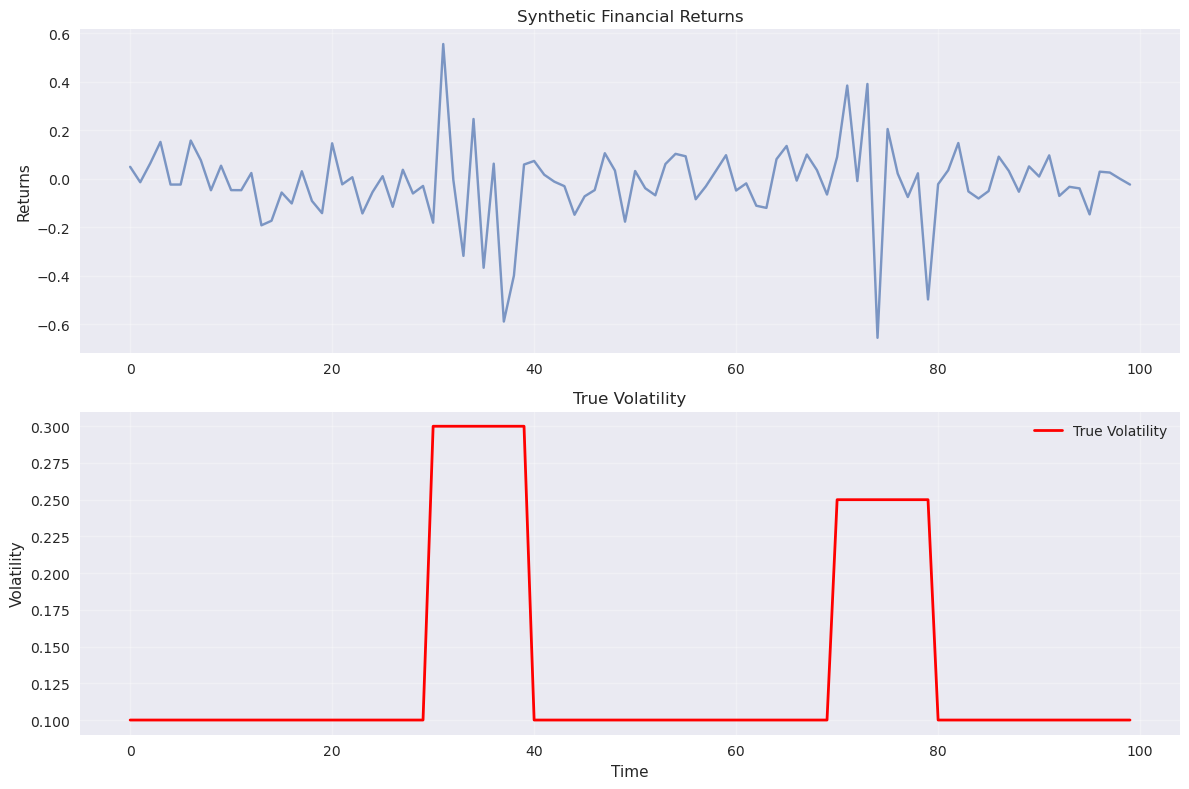

In [ ]:
# Generate synthetic financial returns data for demonstration
np.random.seed(RANDOM_SEED)
n_periods = 100
true_volatility = np.ones(n_periods) * 0.1

# Add periods of high volatility
true_volatility[30:40] = 0.3
true_volatility[70:80] = 0.25

# Generate returns
returns = np.random.normal(0, true_volatility)

# Visualize the synthetic data
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

ax1.plot(returns, alpha=0.7)
ax1.set_title('Synthetic Financial Returns')
ax1.set_ylabel('Returns')
ax1.grid(True, alpha=0.3)

ax2.plot(true_volatility, color='red', linewidth=2, label='True Volatility')
ax2.set_title('True Volatility')
ax2.set_xlabel('Time')
ax2.set_ylabel('Volatility')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [ ]:
# Stochastic volatility model
with pm.Model() as stoch_vol_model:
    # Mean return
    mu = pm.Normal('mu', mu=0, sigma=0.1)
    
    # Volatility process parameters
    tau = pm.HalfNormal('tau', sigma=0.2)  # Innovation in log-volatility
    
    # Log-volatility random walk
    init_dist = pm.Normal.dist(mu=np.log(0.1), sigma=1)
    log_sigma = pm.GaussianRandomWalk('log_sigma',
                                     mu=0,
                                     sigma=tau,
                                     init_dist=init_dist,
                                     steps=n_periods-1)
    
    # Convert to volatility
    sigma = pm.Deterministic('sigma', pm.math.exp(log_sigma))
    
    # Likelihood
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=returns)

# This model can be challenging to sample, so we'll use more aggressive settings
with stoch_vol_model:
    trace_sv = pm.sample(1000, tune=2000, target_accept=0.9, random_seed=RANDOM_SEED, chains=2)

print("Stochastic Volatility Model Summary:")
print(az.summary(trace_sv, var_names=['mu', 'tau']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [mu, tau, log_sigma]


Output()

Sampling 2 chains for 2_000 tune and 1_000 draw iterations (4_000 + 2_000 draws total) took 6 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


Stochastic Volatility Model Summary:
      mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
mu  -0.008  0.010  -0.029    0.009      0.000    0.000    2585.0    1461.0   
tau  0.253  0.056   0.151    0.355      0.004    0.002     148.0     232.0   

     r_hat  
mu    1.00  
tau   1.01  


tau_posterior shape: (2, 1000)
Mean tau value: 0.2532298404142941


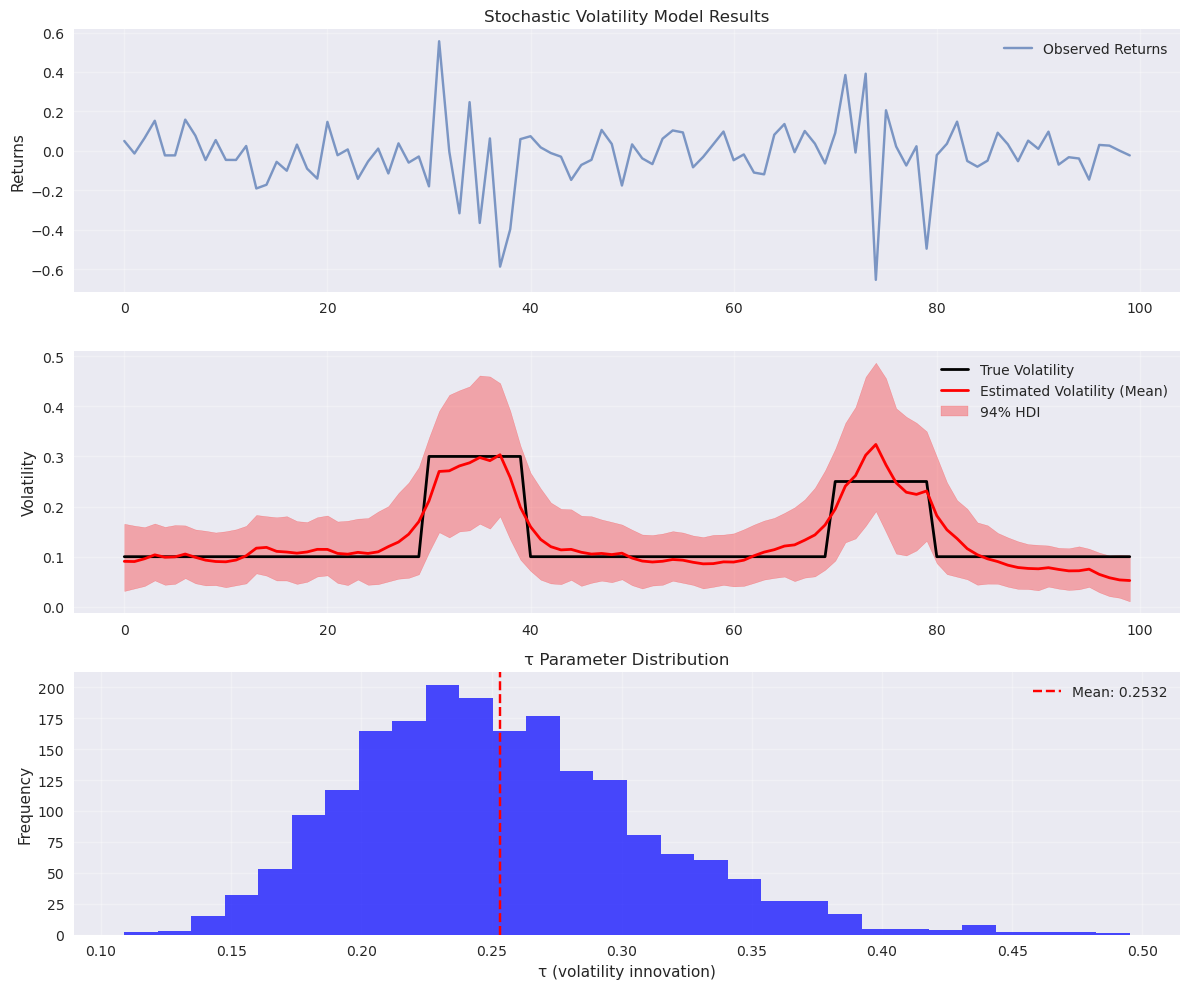

In [ ]:
# Extract the posterior directly from the trace
posterior_sigma = trace_sv.posterior['sigma']
# Calculate the mean across chains and draws
sigma_mean_direct = posterior_sigma.mean(dim=['chain', 'draw']).values

# Calculate HDI for sigma
sigma_hdi = az.hdi(trace_sv, var_names=['sigma'], hdi_prob=0.94)['sigma'].values

# Plot with this new mean
plt.figure(figsize=(12, 10))

# Returns
plt.subplot(3, 1, 1)
plt.plot(returns, alpha=0.7, label='Observed Returns')
plt.ylabel('Returns')
plt.title('Stochastic Volatility Model Results')
plt.legend()
plt.grid(True, alpha=0.3)

# Estimated vs true volatility
plt.subplot(3, 1, 2)
plt.plot(true_volatility, 'k-', linewidth=2, label='True Volatility')
plt.plot(sigma_mean_direct, 'r-', linewidth=2, label='Estimated Volatility (Mean)')
plt.fill_between(range(len(sigma_hdi)), 
                sigma_hdi[:, 0], sigma_hdi[:, 1], 
                alpha=0.3, color='red', label='94% HDI')
plt.ylabel('Volatility')
plt.legend()
plt.grid(True, alpha=0.3)

# Fix the tau parameter visualization
plt.subplot(3, 1, 3)
# Extract tau posterior samples
tau_posterior = trace_sv.posterior['tau']
print(f"tau_posterior shape: {tau_posterior.shape}")

# Calculate the mean tau value (scalar)
tau_mean_value = tau_posterior.mean().values
print(f"Mean tau value: {tau_mean_value}")

# Create a histogram of tau values
tau_values = tau_posterior.values.flatten()  # Flatten all dimensions
plt.hist(tau_values, bins=30, alpha=0.7, color='blue')
plt.axvline(x=tau_mean_value, color='red', linestyle='--', 
           label=f'Mean: {tau_mean_value:.4f}')
plt.ylabel('Frequency')
plt.xlabel('τ (volatility innovation)')
plt.title('τ Parameter Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()

### Multivariate Time Series Models

PyMC also supports multivariate time series through specialized distributions that model relationships between multiple related time series.

#### Multivariate Gaussian Random Walks

```python
# Multivariate random walk with correlation
with pm.Model() as mv_model:
    # Covariance matrix for innovations
    cov_matrix = pm.LKJ('cov_matrix', n=n_series, eta=2)
    
    # Multivariate random walk
    mv_walk = pm.MvGaussianRandomWalk('mv_walk', mu=0, cov=cov_matrix, steps=n_obs-1)
    
    # Observations
    obs = pm.MvNormal('obs', mu=mv_walk, cov=obs_cov, observed=data)
```

**Applications:**
- **Multiple financial assets**: Joint modeling of stock prices
- **Regional data**: Related time series across geographic areas  
- **Sensor networks**: Correlated measurements from multiple devices
- **Economic indicators**: Joint dynamics of inflation, unemployment, GDP

### Gaussian Process Regression for Time Series

Gaussian Processes (GPs) provide a flexible, non-parametric approach to time series modeling that can capture complex temporal patterns without specifying a fixed functional form.

**What is a Gaussian Process?**

A Gaussian Process is a collection of random variables, any finite subset of which has a multivariate normal distribution. For time series, we can think of it as:

$$f(t) \sim \mathcal{GP}(m(t), k(t, t'))$$

Where:
- $m(t)$ = mean function (often set to zero)
- $k(t, t')$ = covariance function (kernel) that determines smoothness

**Key Kernel Functions for Time Series:**

1. **Squared Exponential (RBF)**: $k(t, t') = \sigma^2 \exp\left(-\frac{(t-t')^2}{2\ell^2}\right)$
   - Smooth, infinitely differentiable functions
   - Length scale $\ell$ controls how quickly correlation decays

2. **Periodic**: $k(t, t') = \sigma^2 \exp\left(-\frac{2\sin^2(\pi|t-t'|/p)}{\ell^2}\right)$
   - Captures repeating patterns
   - Period $p$ and length scale $\ell$

**Advantages for Time Series:**
- **Non-parametric**: No need to specify functional form
- **Uncertainty quantification**: Natural prediction intervals
- **Kernel composition**: Combine kernels for complex patterns
- **Irregularly spaced data**: Natural handling of missing time points

Let's implement these advanced models:

In [ ]:
# Gaussian Process model for the sales data
# Using a subset for computational efficiency
subset_size = min(50, len(store_item_data))
subset_idx = np.linspace(0, len(store_item_data)-1, subset_size, dtype=int)
X_gp = time_normalized[subset_idx].reshape(-1, 1)
y_gp = y_obs[subset_idx]

with pm.Model() as gp_model:
    # GP hyperparameters
    length_scale = pm.HalfNormal('length_scale', sigma=2.0)
    eta = pm.HalfNormal('eta', sigma=1.0)  # marginal standard deviation
    
    # Define the covariance function
    cov_func = eta**2 * pm.gp.cov.ExpQuad(1, ls=length_scale)
    
    # GP prior
    gp = pm.gp.Marginal(cov_func=cov_func)
    
    # Observation noise
    sigma_gp = pm.HalfNormal('sigma_gp', sigma=0.5)
    
    # Observed data
    y_pred = gp.marginal_likelihood('y_pred', X=X_gp, y=y_gp, sigma=sigma_gp)

# Sample from the model
with gp_model:
    trace_gp = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

print("Gaussian Process Model Summary:")
print(az.summary(trace_gp, var_names=['length_scale', 'eta', 'sigma_gp']))

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [length_scale, eta, sigma_gp]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 5 seconds.
There were 5 divergences after tuning. Increase `target_accept` or reparameterize.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Gaussian Process Model Summary:
               mean     sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  \
length_scale  0.092  0.017   0.067    0.118      0.001    0.002     638.0   
eta           0.978  0.151   0.742    1.304      0.005    0.004     889.0   
sigma_gp      0.196  0.074   0.070    0.359      0.003    0.003     700.0   

              ess_tail  r_hat  
length_scale     410.0    1.0  
eta              934.0    1.0  
sigma_gp         402.0    1.0  


Sampling: [gp_pred]


Output()

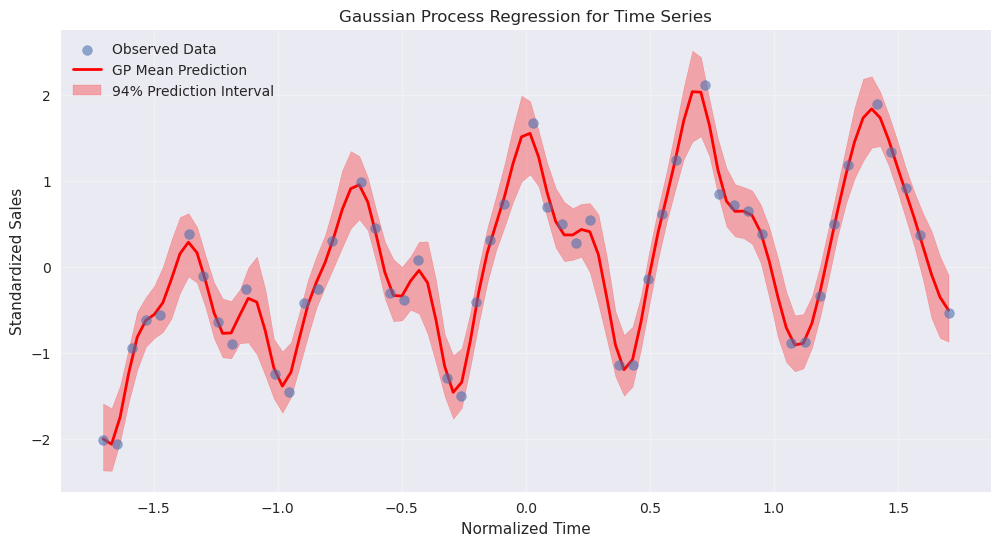

In [ ]:
# Generate predictions from the GP model
X_pred = np.linspace(X_gp.min(), X_gp.max(), 100).reshape(-1, 1)

with gp_model:
    # Conditional distribution at prediction points
    gp_pred = gp.conditional('gp_pred', Xnew=X_pred)
    
    # Sample from the posterior predictive
    pred_samples = pm.sample_posterior_predictive(trace_gp, var_names=['gp_pred'], random_seed=RANDOM_SEED)

# Extract predictions
gp_predictions = pred_samples.posterior_predictive['gp_pred'].values
gp_mean = np.mean(gp_predictions, axis=(0, 1))
gp_hdi = np.percentile(gp_predictions, [3, 97], axis=(0, 1))

# Visualize GP results
plt.figure(figsize=(12, 6))
plt.scatter(X_gp.flatten(), y_gp, alpha=0.6, s=50, label='Observed Data', zorder=3)
plt.plot(X_pred.flatten(), gp_mean, 'r-', linewidth=2, label='GP Mean Prediction')
plt.fill_between(X_pred.flatten(), gp_hdi[0], gp_hdi[1], 
                alpha=0.3, color='red', label='94% Prediction Interval')
plt.xlabel('Normalized Time')
plt.ylabel('Standardized Sales')
plt.title('Gaussian Process Regression for Time Series')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

---

## Section 5: Model Evaluation and Selection (10 minutes)

### Posterior Predictive Checks

Posterior predictive checks are essential for validating Bayesian models. They help us assess whether our model can generate data that looks similar to what we actually observed.

**The Process:**
1. **Sample from posterior**: Get parameter samples from MCMC
2. **Generate synthetic data**: Use posterior samples to simulate new datasets
3. **Compare with observed**: Check if synthetic data resembles real data
4. **Identify discrepancies**: Look for systematic differences

**Key Diagnostic Plots:**
- **Observed vs Predicted scatter plots**: Should lie along 45-degree line
- **Residual plots**: Should show no systematic patterns
- **Distribution comparisons**: Histograms of observed vs synthetic data
- **Time series plots**: Overlay predictions with observations

**What to Look For:**
- **Systematic bias**: Consistent over/under-prediction
- **Heteroscedasticity**: Changing variance over time or levels
- **Missing patterns**: Model fails to capture important features
- **Outlier sensitivity**: Model breaks down with extreme values

Sampling: [y_pred]


Output()

Sampling: [y_pred]


Output()

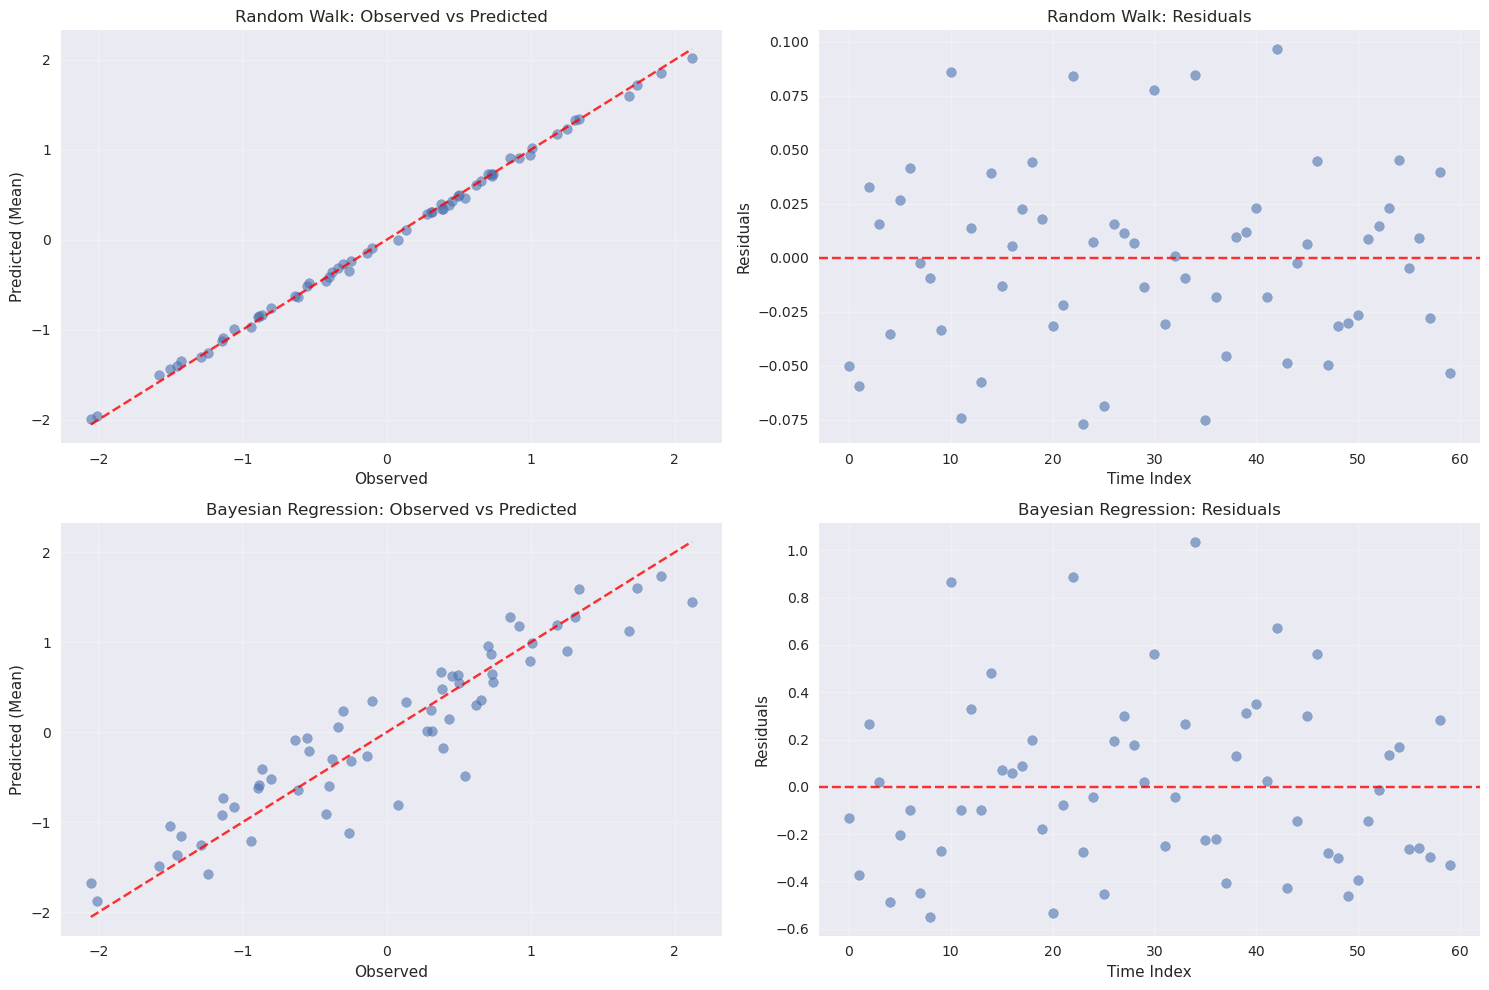

In [ ]:
# Posterior predictive checks for our models
models_to_compare = {
    'Random Walk': (random_walk_model, trace_rw),
    'Bayesian Regression': (regression_model, trace_reg)
}

fig, axes = plt.subplots(2, 2, figsize=(15, 10))
axes = axes.flatten()

for i, (model_name, (model, trace)) in enumerate(models_to_compare.items()):
    with model:
        # Generate posterior predictive samples
        ppc = pm.sample_posterior_predictive(trace, random_seed=RANDOM_SEED)
    
    # Extract predictions
    if 'y_pred' in ppc.posterior_predictive:
        y_pred_samples = ppc.posterior_predictive['y_pred'].values
    else:
        y_pred_samples = ppc.posterior_predictive[list(ppc.posterior_predictive.keys())[0]].values
    
    # Plot observed vs predicted
    ax = axes[i*2]
    ax.scatter(y_obs, np.mean(y_pred_samples, axis=(0, 1)), alpha=0.6)
    ax.plot([y_obs.min(), y_obs.max()], [y_obs.min(), y_obs.max()], 'r--', alpha=0.8)
    ax.set_xlabel('Observed')
    ax.set_ylabel('Predicted (Mean)')
    ax.set_title(f'{model_name}: Observed vs Predicted')
    ax.grid(True, alpha=0.3)
    
    # Plot residuals
    ax = axes[i*2 + 1]
    residuals = y_obs - np.mean(y_pred_samples, axis=(0, 1))
    ax.scatter(range(len(residuals)), residuals, alpha=0.6)
    ax.axhline(y=0, color='red', linestyle='--', alpha=0.8)
    ax.set_xlabel('Time Index')
    ax.set_ylabel('Residuals')
    ax.set_title(f'{model_name}: Residuals')
    ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Cross-Validation for Time Series

Time series cross-validation requires special consideration due to temporal dependence. We cannot randomly split the data as in cross-sectional analysis.

#### Time Series Cross-Validation Strategies

1. **Walk-Forward Validation**: Use expanding window of training data
   - Train on [1:t], test on [t+1:t+h]
   - Move forward one step, train on [1:t+1], test on [t+2:t+h+1]
   - Repeat for entire series

2. **Rolling Window Validation**: Use fixed window of training data
   - Train on [t-w:t], test on [t+1:t+h]
   - Move forward, train on [t-w+1:t+1], test on [t+2:t+h+1]

#### Implementation Considerations

```python
# Example walk-forward validation
def time_series_cv(data, window_size, forecast_horizon):
    scores = []
    for i in range(window_size, len(data) - forecast_horizon):
        train_data = data[:i]
        test_data = data[i:i+forecast_horizon]
        # Fit model on train_data, evaluate on test_data
        score = evaluate_model(train_data, test_data)
        scores.append(score)
    return scores
```

### Forecast Evaluation Metrics

When evaluating time series forecasts, multiple metrics provide different perspectives:

#### Point Forecast Metrics
- **Mean Absolute Error (MAE)**: $\frac{1}{h}\sum_{i=1}^h |y_{T+i} - \hat{y}_{T+i}|$
- **Root Mean Square Error (RMSE)**: $\sqrt{\frac{1}{h}\sum_{i=1}^h (y_{T+i} - \hat{y}_{T+i})^2}$
- **Mean Absolute Percentage Error (MAPE)**: $\frac{100}{h}\sum_{i=1}^h \left|\frac{y_{T+i} - \hat{y}_{T+i}}{y_{T+i}}\right|$

#### Probabilistic Forecast Metrics
- **Coverage Probability**: Fraction of observations within prediction intervals
- **Interval Width**: Average width of prediction intervals
- **Continuous Ranked Probability Score (CRPS)**: Quality of full predictive distribution

### Bayesian Model Averaging

Instead of selecting a single "best" model, Bayesian model averaging (BMA) combines predictions from multiple models weighted by their posterior model probabilities.

$$p(y_{new} | \text{data}) = \sum_{k=1}^K p(y_{new} | M_k, \text{data}) \cdot p(M_k | \text{data})$$

Where:
- $M_k$ = model k
- $p(M_k | \text{data})$ = posterior model probability
- $p(y_{new} | M_k, \text{data})$ = prediction from model k

**Implementation:**
```python
# Model weights based on WAIC
model_weights = np.exp(-0.5 * (waic_values - np.min(waic_values)))
model_weights /= np.sum(model_weights)

# Weighted average of predictions
bma_forecast = np.sum([w * pred for w, pred in zip(model_weights, predictions)], axis=0)
```

**Benefits:**
- **Robust predictions**: Less sensitive to model selection uncertainty
- **Better calibration**: More reliable uncertainty quantification
- **Automatic weighting**: No need for manual model selection

Let's implement model comparison and evaluation:

In [ ]:
# Model comparison using WAIC and LOO
model_comparison = {}

for model_name, (model, trace) in models_to_compare.items():

    try:
        with model:
            pm.compute_log_likelihood(trace)
    except ValueError as e:
        pass

    # Compute WAIC
    waic_data = az.waic(trace)
    
    # Compute LOO-CV
    loo_data = az.loo(trace)
    
    model_comparison[model_name] = {
        'WAIC': float(waic_data.elpd_waic * -2),  # Convert to WAIC scale
        'WAIC_SE': float(waic_data.se * 2),       # Scale the standard error
        'LOO': float(loo_data.elpd_loo * -2),     # Convert to LOO scale
        'LOO_SE': float(loo_data.se * 2),         # Scale the standard error
        'p_WAIC': float(waic_data.p_waic),
        'p_LOO': float(loo_data.p_loo)
    }

# Create comparison DataFrame using polars
comparison_df = pl.DataFrame(model_comparison).transpose(include_header=True)
print("Model Comparison:")
print(comparison_df)

# Visualize comparison
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

models = list(model_comparison.keys())
waic_values = [model_comparison[m]['WAIC'] for m in models]
waic_errors = [model_comparison[m]['WAIC_SE'] for m in models]
loo_values = [model_comparison[m]['LOO'] for m in models]
loo_errors = [model_comparison[m]['LOO_SE'] for m in models]

x_pos = np.arange(len(models))

ax1.bar(x_pos, waic_values, yerr=waic_errors, capsize=5, alpha=0.7)
ax1.set_xlabel('Model')
ax1.set_ylabel('WAIC')
ax1.set_title('WAIC Comparison (Lower is Better)')
ax1.set_xticks(x_pos)
ax1.set_xticklabels(models)
ax1.grid(True, alpha=0.3)

ax2.bar(x_pos, loo_values, yerr=loo_errors, capsize=5, alpha=0.7, color='orange')
ax2.set_xlabel('Model')
ax2.set_ylabel('LOO')
ax2.set_title('LOO Comparison (Lower is Better)')
ax2.set_xticks(x_pos)
ax2.set_xticklabels(models)
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine best model
best_waic = min(waic_values)
best_model_waic = models[waic_values.index(best_waic)]
print(f"\nBest model by WAIC: {best_model_waic} (WAIC = {best_waic:.3f})")

best_loo = min(loo_values)
best_model_loo = models[loo_values.index(best_loo)]
print(f"Best model by LOO: {best_model_loo} (LOO = {best_loo:.3f})")

---

## Section 6: Forecasting with Bayesian Models (10 minutes)

### Generating Predictions with Uncertainty

One of the key advantages of Bayesian methods is the ability to generate probabilistic forecasts that naturally quantify uncertainty about future values.

**The Bayesian Forecasting Process:**

1. **Posterior Sampling**: Use MCMC samples of model parameters
2. **Future Value Generation**: For each parameter sample, generate future observations
3. **Aggregation**: Combine across all samples to get predictive distribution
4. **Uncertainty Quantification**: Extract means, intervals, and full distributions

**Mathematical Framework:**

For h-step-ahead forecasting:
$$p(y_{T+h} | y_{1:T}) = \int p(y_{T+h} | \theta) p(\theta | y_{1:T}) d\theta$$

Where:
- $y_{1:T}$ = observed training data
- $y_{T+h}$ = forecast h steps ahead
- $\theta$ = model parameters
- $p(\theta | y_{1:T})$ = posterior distribution

**Types of Uncertainty:**

1. **Parameter Uncertainty**: Uncertainty about model parameters
2. **Model Uncertainty**: Uncertainty about model structure
3. **Observation Uncertainty**: Random noise in observations
4. **Structural Uncertainty**: Unknown changes in underlying process

### Forecast Evaluation Metrics

When true future values are available, we can evaluate forecast quality using multiple criteria:

#### Point Forecast Metrics
- **Mean Absolute Error (MAE)**: $\frac{1}{h}\sum_{i=1}^h |y_{T+i} - \hat{y}_{T+i}|$
- **Root Mean Square Error (RMSE)**: $\sqrt{\frac{1}{h}\sum_{i=1}^h (y_{T+i} - \hat{y}_{T+i})^2}$
- **Mean Absolute Percentage Error (MAPE)**: $\frac{100}{h}\sum_{i=1}^h \left|\frac{y_{T+i} - \hat{y}_{T+i}}{y_{T+i}}\right|$

#### Probabilistic Forecast Metrics
- **Coverage Probability**: Fraction of observations falling within prediction intervals
- **Interval Width**: Average width of prediction intervals
- **Continuous Ranked Probability Score (CRPS)**: Measures quality of full predictive distribution

#### Time Series Specific Considerations
- **Forecast Horizon**: Accuracy typically decreases with longer horizons
- **Seasonality**: Models should capture seasonal patterns accurately
- **Trend Changes**: Ability to adapt to structural breaks
- **Extreme Values**: Performance during unusual periods

### Best Practices for Bayesian Forecasting

1. **Validate with Out-of-Sample Data**: Always test on data not used for training
2. **Use Multiple Forecast Horizons**: Assess performance at 1, 3, 6, 12 steps ahead
3. **Compare with Benchmarks**: Simple models (random walk, seasonal naive) as baselines
4. **Consider Ensemble Approaches**: Combine forecasts from multiple models
5. **Monitor Forecast Quality**: Track performance over time and update models as needed

Let's implement forecasting with our best-performing model:

In [ ]:
# Live coding example: Forecasting future values
# Use the best performing model (Bayesian regression) for forecasting

# Define future time points
n_forecast = 12  # Forecast 12 periods ahead
last_time_idx = time_idx[-1]
future_time_idx = np.arange(last_time_idx + 1, last_time_idx + 1 + n_forecast)
future_time_normalized = (future_time_idx - time_idx.mean()) / time_idx.std()

# Create seasonal features for future periods
future_sin_seasonal = np.sin(seasonal_freq * future_time_idx)
future_cos_seasonal = np.cos(seasonal_freq * future_time_idx)

# Extract parameter samples from the regression model
alpha_samples = az.extract(trace_reg)['alpha'].values
beta_samples = az.extract(trace_reg)['beta'].values
gamma_samples = az.extract(trace_reg)['gamma'].values
delta_samples = az.extract(trace_reg)['delta'].values
sigma_samples = az.extract(trace_reg)['sigma'].values

# Generate forecasts
n_samples = len(alpha_samples)
forecasts = np.zeros((n_samples, n_forecast))

for i in range(n_samples):
    # Compute mean prediction for each future time point
    mu_future = (alpha_samples[i] + 
                beta_samples[i] * future_time_normalized + 
                gamma_samples[i] * future_sin_seasonal + 
                delta_samples[i] * future_cos_seasonal)
    
    # Add observation noise
    forecasts[i, :] = np.random.normal(mu_future, sigma_samples[i])

# Compute forecast statistics
forecast_mean = np.mean(forecasts, axis=0)
forecast_std = np.std(forecasts, axis=0)
forecast_hdi = np.percentile(forecasts, [3, 97], axis=0)

# Convert back to original scale
forecast_mean_orig = forecast_mean * sales_std + sales_mean
forecast_hdi_orig = forecast_hdi * sales_std + sales_mean
forecast_std_orig = forecast_std * sales_std

print(f"Generated {n_forecast} period forecast with {n_samples} samples")
print(f"Forecast summary (original scale):")
print(f"Mean: {forecast_mean_orig.mean():.1f} ± {forecast_std_orig.mean():.1f}")
print(f"Range: [{forecast_hdi_orig[0].min():.1f}, {forecast_hdi_orig[1].max():.1f}]")

Generated 12 period forecast with 2000 samples
Forecast summary (original scale):
Mean: 740.7 ± 56.8
Range: [457.9, 1005.7]


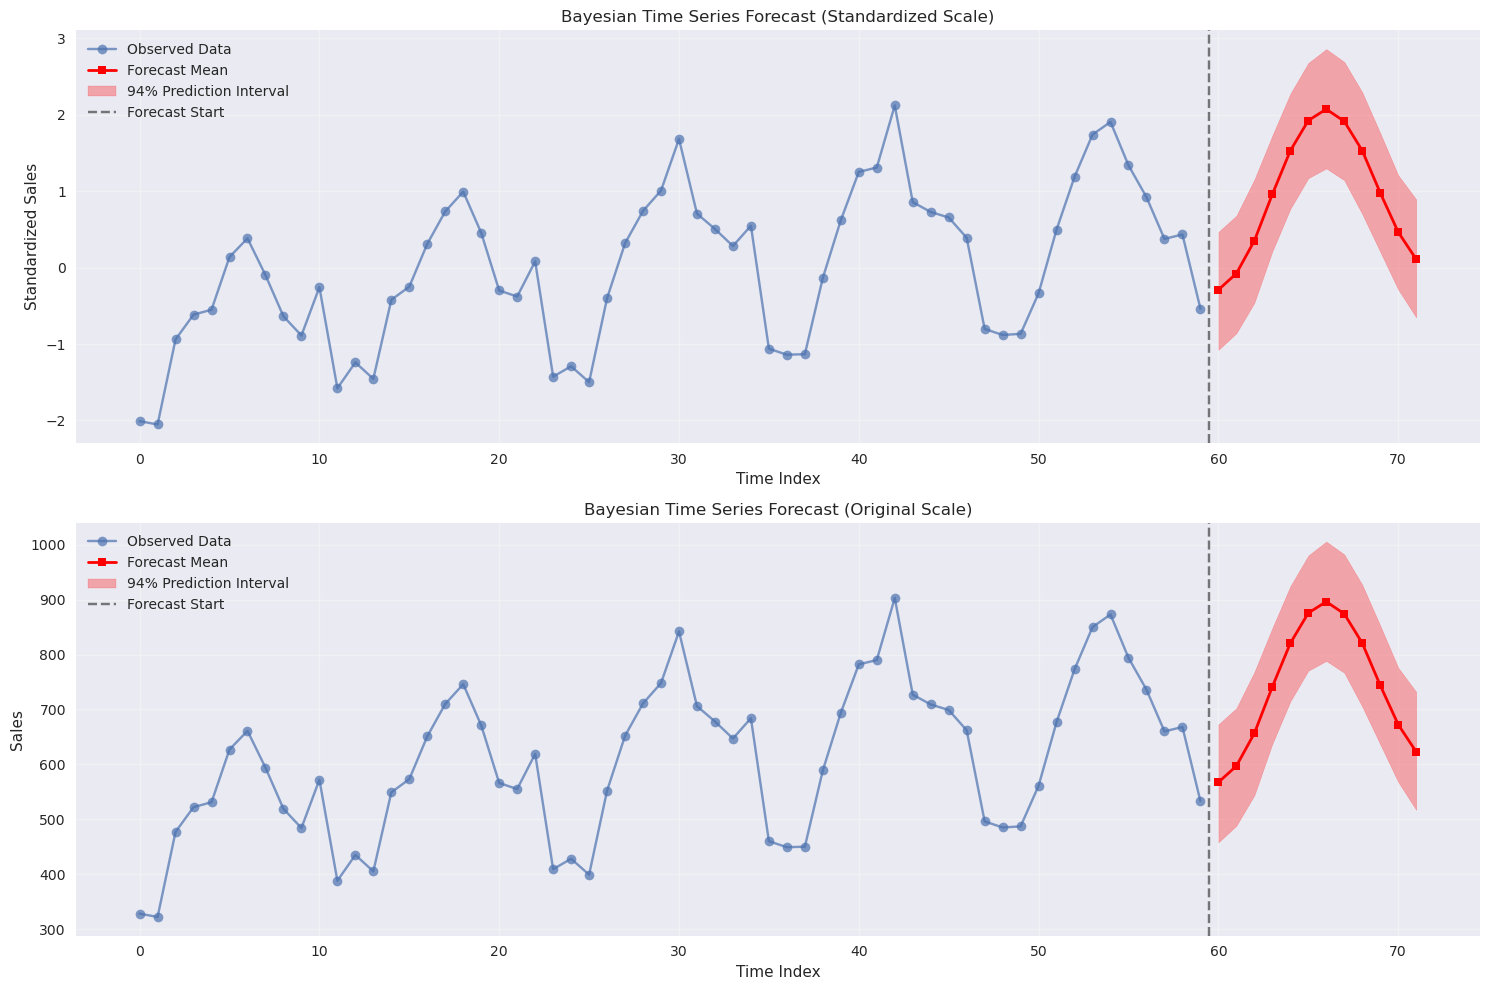

In [ ]:
# Visualize forecasts
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(15, 10))

# Standardized scale
ax1.plot(time_idx, y_obs, 'o-', alpha=0.7, label='Observed Data')
ax1.plot(future_time_idx, forecast_mean, 's-', color='red', linewidth=2, 
         markersize=6, label='Forecast Mean')
ax1.fill_between(future_time_idx, forecast_hdi[0], forecast_hdi[1], 
                alpha=0.3, color='red', label='94% Prediction Interval')
ax1.axvline(x=last_time_idx + 0.5, color='black', linestyle='--', alpha=0.5, label='Forecast Start')
ax1.set_xlabel('Time Index')
ax1.set_ylabel('Standardized Sales')
ax1.set_title('Bayesian Time Series Forecast (Standardized Scale)')
ax1.legend()
ax1.grid(True, alpha=0.3)

# Original scale
y_obs_orig = y_obs * sales_std + sales_mean
ax2.plot(time_idx, y_obs_orig, 'o-', alpha=0.7, label='Observed Data')
ax2.plot(future_time_idx, forecast_mean_orig, 's-', color='red', linewidth=2, 
         markersize=6, label='Forecast Mean')
ax2.fill_between(future_time_idx, forecast_hdi_orig[0], forecast_hdi_orig[1], 
                alpha=0.3, color='red', label='94% Prediction Interval')
ax2.axvline(x=last_time_idx + 0.5, color='black', linestyle='--', alpha=0.5, label='Forecast Start')
ax2.set_xlabel('Time Index')
ax2.set_ylabel('Sales')
ax2.set_title('Bayesian Time Series Forecast (Original Scale)')
ax2.legend()
ax2.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

### Forecast Evaluation Metrics

When true future values are available, we can evaluate forecast quality:

Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (2 chains in 2 jobs)
NUTS: [alpha, beta, gamma, delta, sigma]


Output()

Sampling 2 chains for 1_000 tune and 1_000 draw iterations (2_000 + 2_000 draws total) took 1 seconds.
We recommend running at least 4 chains for robust computation of convergence diagnostics


Forecast Evaluation Metrics:
Mean Absolute Error (MAE): 0.3740
Root Mean Square Error (RMSE): 0.4375
Mean Absolute Percentage Error (MAPE): 62.63%

Probabilistic Metrics:
94% Prediction Interval Coverage: 100.0%
Mean Interval Width: 1.6315


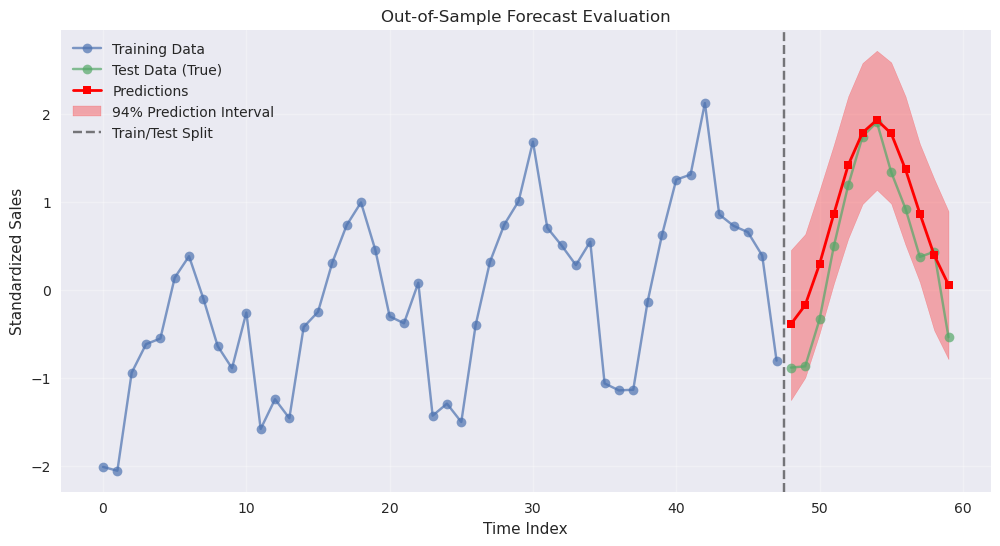

In [ ]:
# Demonstrate forecast evaluation using cross-validation
# Split data for out-of-sample evaluation
split_point = int(0.8 * len(y_obs))  # Use 80% for training
y_train = y_obs[:split_point]
y_test = y_obs[split_point:]
time_train = time_normalized[:split_point]
time_test = time_normalized[split_point:]

# Refit model on training data
sin_train = np.sin(seasonal_freq * time_idx[:split_point])
cos_train = np.cos(seasonal_freq * time_idx[:split_point])

with pm.Model() as eval_model:
    # Same model structure as before
    alpha = pm.Normal('alpha', mu=0, sigma=1)
    beta = pm.Normal('beta', mu=0, sigma=1)
    gamma = pm.Normal('gamma', mu=0, sigma=1)
    delta = pm.Normal('delta', mu=0, sigma=1)
    
    mu = alpha + beta * time_train + gamma * sin_train + delta * cos_train
    sigma = pm.HalfNormal('sigma', sigma=1)
    
    y_pred = pm.Normal('y_pred', mu=mu, sigma=sigma, observed=y_train)

# Fit model
with eval_model:
    trace_eval = pm.sample(1000, tune=1000, random_seed=RANDOM_SEED, chains=2)

# Generate predictions for test period
sin_test = np.sin(seasonal_freq * time_idx[split_point:])
cos_test = np.cos(seasonal_freq * time_idx[split_point:])

alpha_eval = az.extract(trace_eval)['alpha'].values
beta_eval = az.extract(trace_eval)['beta'].values
gamma_eval = az.extract(trace_eval)['gamma'].values
delta_eval = az.extract(trace_eval)['delta'].values
sigma_eval = az.extract(trace_eval)['sigma'].values

n_test = len(y_test)
n_eval_samples = len(alpha_eval)
test_predictions = np.zeros((n_eval_samples, n_test))

for i in range(n_eval_samples):
    mu_test = (alpha_eval[i] + 
              beta_eval[i] * time_test + 
              gamma_eval[i] * sin_test + 
              delta_eval[i] * cos_test)
    test_predictions[i, :] = np.random.normal(mu_test, sigma_eval[i])

# Compute evaluation metrics
pred_mean = np.mean(test_predictions, axis=0)
pred_std = np.std(test_predictions, axis=0)

# Point forecast metrics
mae = np.mean(np.abs(y_test - pred_mean))
rmse = np.sqrt(np.mean((y_test - pred_mean)**2))
mape = np.mean(np.abs((y_test - pred_mean) / y_test)) * 100

# Probabilistic forecast metrics
# Coverage probability (what fraction of observations fall within prediction intervals)
pred_hdi = np.percentile(test_predictions, [3, 97], axis=0)
coverage = np.mean((y_test >= pred_hdi[0]) & (y_test <= pred_hdi[1]))

# Mean interval width
interval_width = np.mean(pred_hdi[1] - pred_hdi[0])

print("Forecast Evaluation Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Root Mean Square Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Percentage Error (MAPE): {mape:.2f}%")
print(f"\nProbabilistic Metrics:")
print(f"94% Prediction Interval Coverage: {coverage:.1%}")
print(f"Mean Interval Width: {interval_width:.4f}")

# Visualize out-of-sample performance
plt.figure(figsize=(12, 6))
full_time = np.arange(len(y_obs))
plt.plot(full_time[:split_point], y_train, 'o-', alpha=0.7, label='Training Data')
plt.plot(full_time[split_point:], y_test, 'o-', alpha=0.7, label='Test Data (True)')
plt.plot(full_time[split_point:], pred_mean, 's-', color='red', linewidth=2, 
         markersize=6, label='Predictions')
plt.fill_between(full_time[split_point:], pred_hdi[0], pred_hdi[1], 
                alpha=0.3, color='red', label='94% Prediction Interval')
plt.axvline(x=split_point - 0.5, color='black', linestyle='--', alpha=0.5, label='Train/Test Split')
plt.xlabel('Time Index')
plt.ylabel('Standardized Sales')
plt.title('Out-of-Sample Forecast Evaluation')
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [ ]:
---

## Conclusion and Next Steps

### What We've Covered Today

1. **Section 1: Introduction (20 minutes)**
   - Motivation for Bayesian time series analysis
   - Key characteristics of time series data  
   - Data preprocessing techniques

2. **Section 2: Bayesian Inference and PyMC (10 minutes)**
   - Bayesian inference concepts
   - PyMC API and workflow
   - MCMC sampling with NUTS

3. **Section 3: Basic Bayesian Time Series Models (20 minutes)**
   - Gaussian Random Walks
   - Autoregressive (AR) models
   - Bayesian regression for time series

4. **Section 4: Advanced Models (25 minutes)**
   - State-Space Models
   - Stochastic Volatility Models
   - Gaussian Process regression
   - Multivariate time series

5. **Section 5: Model Evaluation and Selection (10 minutes)**
   - Posterior predictive checks
   - Information criteria (WAIC, LOO)
   - Cross-validation and forecast metrics
   - Bayesian model averaging

6. **Section 6: Forecasting (10 minutes)**
   - Generating probabilistic predictions
   - Uncertainty quantification
   - Forecast evaluation

### Key Takeaways

- **Uncertainty Quantification**: Bayesian methods naturally provide uncertainty estimates
- **Model Flexibility**: PyMC allows complex, hierarchical model structures  
- **Prior Information**: Can incorporate domain expertise through informative priors
- **Model Comparison**: Information criteria help select optimal models
- **Probabilistic Forecasts**: More informative than point predictions

### Resources for Continued Learning

- **PyMC Examples**: [docs.pymc.io/en/stable/learn/gallery.html](https://docs.pymc.io/en/stable/learn/gallery.html)
- **Time Series with PyMC**: [pymc.io/projects/examples/en/latest/time_series/](https://www.pymc.io/projects/examples/en/latest/time_series/index.html)
- **ArviZ Documentation**: [arviz-devs.github.io/arviz/](https://arviz-devs.github.io/arviz/)

### Thank You!

**Questions and Discussion Welcome**

Contact: @fonnesbeck (GitHub/Twitter)

---

## Conclusion and Next Steps

### What We've Covered

1. **Bayesian Fundamentals**: Understanding the advantages of Bayesian approaches for time series
2. **PyMC Basics**: Model specification, sampling, and diagnostics
3. **Time Series Components**: Trend, seasonality, and noise modeling
4. **Model Portfolio**: From simple random walks to advanced state-space models
5. **Evaluation Methods**: Information criteria, posterior predictive checks
6. **Probabilistic Forecasting**: Generating predictions with uncertainty quantification

### Key Takeaways

- **Uncertainty Quantification**: Bayesian methods naturally provide uncertainty estimates
- **Model Flexibility**: PyMC allows complex, hierarchical model structures
- **Prior Information**: Can incorporate domain expertise through informative priors
- **Model Comparison**: Information criteria help select optimal models
- **Probabilistic Forecasts**: More informative than point predictions

### Next Steps for Learning

1. **Advanced Models**: Explore Vector Autoregression (VAR), Dynamic Linear Models
2. **Hierarchical Models**: Multi-level time series with partial pooling
3. **Non-Gaussian Likelihoods**: Count data, binary outcomes, survival analysis
4. **Real-world Applications**: Finance, epidemiology, marketing, IoT sensors
5. **Computational Efficiency**: Variational inference, approximate methods

### Resources for Continued Learning

- **Books**: 
  - "Bayesian Analysis of Time Series" by Lyle Broemeling
  - "Time Series Analysis" by James Hamilton
  - "Bayesian Data Analysis" by Gelman et al.

- **Online Resources**:
  - [PyMC Examples Gallery](https://docs.pymc.io/en/stable/learn/gallery.html)
  - [Bayesian Analysis Recipes](https://github.com/ericmjl/bayesian-analysis-recipes)
  - [Time Series Analysis with PyMC](https://www.pymc.io/projects/examples/en/latest/time_series/index.html)

- **Communities**:
  - PyMC Discourse Forum
  - Stack Overflow (pymc tag)
  - Twitter/X: @pymc_devs

### Thank You!

Questions and discussion welcome!

**Contact**: 
- GitHub: @fonnesbeck
- Twitter/X: @fonnesbeck
- Email: chris.fonnesbeck@vanderbilt.edu